In [1]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%cd ../code
from model import Model, ModelDiff

%cd ../notebooks

/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/code
/home/xiavatar/Desktop/covidcast_latest/covidcast-nowcast/conv_models/notebooks


In [2]:
#Load data
start_date = datetime(2020, 10, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [3]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,time series values, number of geo_values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1, time series values, number of geo_values)
Y = tf.cast(Y, dtype=tf.float32)

In [4]:
#Initialize model without filter bank

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
lr = 1

model_a = Model(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_A_PATH = "model_a.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_A_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_a.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [5]:
#Training
hist = model_a.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
   epochs = 1000,
)

Epoch 1/1000
1/1 [==============================] - 0s 35ms/step - MSE: 15579827.0000
Epoch 2/1000
1/1 [==============================] - 0s 30ms/step - MSE: 15435941.0000
Epoch 3/1000
1/1 [==============================] - 0s 28ms/step - MSE: 15293826.0000
Epoch 4/1000
1/1 [==============================] - 0s 28ms/step - MSE: 15153506.0000
Epoch 5/1000
1/1 [==============================] - 0s 28ms/step - MSE: 15015006.0000
Epoch 6/1000
1/1 [==============================] - 0s 29ms/step - MSE: 14878343.0000
Epoch 7/1000
1/1 [==============================] - 0s 28ms/step - MSE: 14743531.0000
Epoch 8/1000
1/1 [==============================] - 0s 30ms/step - MSE: 14610577.0000
Epoch 9/1000
1/1 [==============================] - 0s 28ms/step - MSE: 14479480.0000
Epoch 10/1000
1/1 [==============================] - 0s 95ms/step - MSE: 14350237.0000
Epoch 11/1000
1/1 [==============================] - 0s 27ms/step - MSE: 14222831.0000
Epoch 12/1000
1/1 [==============================] -

1/1 [==============================] - 0s 27ms/step - MSE: 7668087.0000
Epoch 96/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7620765.0000
Epoch 97/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7573883.0000
Epoch 98/1000
1/1 [==============================] - 0s 27ms/step - MSE: 7527436.5000
Epoch 99/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7481419.5000
Epoch 100/1000
1/1 [==============================] - 0s 38ms/step - MSE: 7435825.5000
Epoch 101/1000
1/1 [==============================] - 0s 31ms/step - MSE: 7390649.5000
Epoch 102/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7345886.5000
Epoch 103/1000
1/1 [==============================] - 0s 30ms/step - MSE: 7301531.5000
Epoch 104/1000
1/1 [==============================] - 0s 40ms/step - MSE: 7257579.5000
Epoch 105/1000
1/1 [==============================] - 0s 28ms/step - MSE: 7214026.0000
Epoch 106/1000
1/1 [==============================] - 0s 28ms/

1/1 [==============================] - 0s 27ms/step - MSE: 4611021.0000
Epoch 190/1000
1/1 [==============================] - 0s 30ms/step - MSE: 4589338.0000
Epoch 191/1000
1/1 [==============================] - 0s 29ms/step - MSE: 4567817.0000
Epoch 192/1000
1/1 [==============================] - 0s 32ms/step - MSE: 4546455.0000
Epoch 193/1000
1/1 [==============================] - 0s 28ms/step - MSE: 4525251.0000
Epoch 194/1000
1/1 [==============================] - 0s 27ms/step - MSE: 4504202.5000
Epoch 195/1000
1/1 [==============================] - 0s 29ms/step - MSE: 4483310.0000
Epoch 196/1000
1/1 [==============================] - 0s 29ms/step - MSE: 4462571.0000
Epoch 197/1000
1/1 [==============================] - 0s 29ms/step - MSE: 4441983.5000
Epoch 198/1000
1/1 [==============================] - 0s 28ms/step - MSE: 4421547.0000
Epoch 199/1000
1/1 [==============================] - 0s 28ms/step - MSE: 4401259.5000
Epoch 200/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - MSE: 3115294.7500
Epoch 284/1000
1/1 [==============================] - 0s 33ms/step - MSE: 3103875.2500
Epoch 285/1000
1/1 [==============================] - 0s 30ms/step - MSE: 3092527.0000
Epoch 286/1000
1/1 [==============================] - 0s 29ms/step - MSE: 3081249.0000
Epoch 287/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3070040.7500
Epoch 288/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3058902.0000
Epoch 289/1000
1/1 [==============================] - 0s 31ms/step - MSE: 3047832.0000
Epoch 290/1000
1/1 [==============================] - 0s 27ms/step - MSE: 3036830.0000
Epoch 291/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3025896.0000
Epoch 292/1000
1/1 [==============================] - 0s 28ms/step - MSE: 3015028.5000
Epoch 293/1000
1/1 [==============================] - 0s 29ms/step - MSE: 3004228.0000
Epoch 294/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 2289925.0000
Epoch 378/1000
1/1 [==============================] - 0s 26ms/step - MSE: 2283265.2500
Epoch 379/1000
1/1 [==============================] - 0s 26ms/step - MSE: 2276639.5000
Epoch 380/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2270048.5000
Epoch 381/1000
1/1 [==============================] - 0s 26ms/step - MSE: 2263491.2500
Epoch 382/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2256967.7500
Epoch 383/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2250477.7500
Epoch 384/1000
1/1 [==============================] - 0s 26ms/step - MSE: 2244021.2500
Epoch 385/1000
1/1 [==============================] - 0s 34ms/step - MSE: 2237598.0000
Epoch 386/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2231209.0000
Epoch 387/1000
1/1 [==============================] - 0s 27ms/step - MSE: 2224852.5000
Epoch 388/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - MSE: 1786841.8750
Epoch 472/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1782568.0000
Epoch 473/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1778312.6250
Epoch 474/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1774075.2500
Epoch 475/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1769855.6250
Epoch 476/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1765654.0000
Epoch 477/1000
1/1 [==============================] - 0s 32ms/step - MSE: 1761469.8750
Epoch 478/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1757303.6250
Epoch 479/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1753154.7500
Epoch 480/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1749023.0000
Epoch 481/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1744908.7500
Epoch 482/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - MSE: 1452042.2500
Epoch 566/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1449093.5000
Epoch 567/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1446155.5000
Epoch 568/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1443228.6250
Epoch 569/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1440312.1250
Epoch 570/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1437406.5000
Epoch 571/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1434511.5000
Epoch 572/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1431627.1250
Epoch 573/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1428753.6250
Epoch 574/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1425890.6250
Epoch 575/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1423038.1250
Epoch 576/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 27ms/step - MSE: 1216591.5000
Epoch 660/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1214484.7500
Epoch 661/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1212385.5000
Epoch 662/1000
1/1 [==============================] - 0s 32ms/step - MSE: 1210293.7500
Epoch 663/1000
1/1 [==============================] - 0s 34ms/step - MSE: 1208209.1250
Epoch 664/1000
1/1 [==============================] - 0s 29ms/step - MSE: 1206131.7500
Epoch 665/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1204061.6250
Epoch 666/1000
1/1 [==============================] - 0s 31ms/step - MSE: 1201998.7500
Epoch 667/1000
1/1 [==============================] - 0s 31ms/step - MSE: 1199943.1250
Epoch 668/1000
1/1 [==============================] - 0s 30ms/step - MSE: 1197894.5000
Epoch 669/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1195853.1250
Epoch 670/1000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 26ms/step - MSE: 1047465.9375
Epoch 754/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1045948.8750
Epoch 755/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1044437.0000
Epoch 756/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1042930.4375
Epoch 757/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1041429.1250
Epoch 758/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1039933.1250
Epoch 759/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1038442.3125
Epoch 760/1000
1/1 [==============================] - 0s 28ms/step - MSE: 1036956.6250
Epoch 761/1000
1/1 [==============================] - 0s 26ms/step - MSE: 1035476.2500
Epoch 762/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1034000.7500
Epoch 763/1000
1/1 [==============================] - 0s 27ms/step - MSE: 1032530.5000
Epoch 764/1000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 28ms/step - MSE: 924906.6250
Epoch 849/1000
1/1 [==============================] - 0s 32ms/step - MSE: 923823.5625
Epoch 850/1000
1/1 [==============================] - 0s 31ms/step - MSE: 922744.2500
Epoch 851/1000
1/1 [==============================] - 0s 28ms/step - MSE: 921669.3750
Epoch 852/1000
1/1 [==============================] - 0s 29ms/step - MSE: 920599.4375
Epoch 853/1000
1/1 [==============================] - 0s 32ms/step - MSE: 919533.1875
Epoch 854/1000
1/1 [==============================] - 0s 28ms/step - MSE: 918470.6875
Epoch 855/1000
1/1 [==============================] - 0s 26ms/step - MSE: 917412.0000
Epoch 856/1000
1/1 [==============================] - 0s 28ms/step - MSE: 916357.1250
Epoch 857/1000
1/1 [==============================] - 0s 28ms/step - MSE: 915305.8750
Epoch 858/1000
1/1 [==============================] - 0s 38ms/step - MSE: 914258.5000
Epoch 859/1000
1/1 [==============================] - 0s 27ms/step - 

1/1 [==============================] - 0s 27ms/step - MSE: 837832.3125
Epoch 944/1000
1/1 [==============================] - 0s 27ms/step - MSE: 837068.0000
Epoch 945/1000
1/1 [==============================] - 0s 27ms/step - MSE: 836306.1875
Epoch 946/1000
1/1 [==============================] - 0s 30ms/step - MSE: 835547.1875
Epoch 947/1000
1/1 [==============================] - 0s 27ms/step - MSE: 834791.0000
Epoch 948/1000
1/1 [==============================] - 0s 28ms/step - MSE: 834037.4375
Epoch 949/1000
1/1 [==============================] - 0s 27ms/step - MSE: 833286.6250
Epoch 950/1000
1/1 [==============================] - 0s 27ms/step - MSE: 832538.3125
Epoch 951/1000
1/1 [==============================] - 0s 27ms/step - MSE: 831793.0000
Epoch 952/1000
1/1 [==============================] - 0s 27ms/step - MSE: 831050.1875
Epoch 953/1000
1/1 [==============================] - 0s 27ms/step - MSE: 830310.1250
Epoch 954/1000
1/1 [==============================] - 0s 28ms/step - 

In [6]:
#Initialize model with filter bank [1,0,0,0,...], [0,1,0,0,...], [0,0,1,0,...]

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
filter_bank = [[1. if i == j else 0. for j in range(30)] for i in range(30)]
lr = 0.2

model_b = ModelDiff(
    p = p, 
    m = m,
    filter_bank=filter_bank,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam = 1,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_B_PATH = "model_b.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_B_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_b.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [7]:
#Training
hist = model_b.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 2000,
)

Epoch 1/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15582988.0000
Epoch 2/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15552488.0000
Epoch 3/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15523644.0000
Epoch 4/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15494875.0000
Epoch 5/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15466176.0000
Epoch 6/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15437552.0000
Epoch 7/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15409003.0000
Epoch 8/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15380528.0000
Epoch 9/2000
1/1 [==============================] - 0s 31ms/step - MSE: 15352133.0000
Epoch 10/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15323814.0000
Epoch 11/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15295577.0000
Epoch 12/2000
1/1 [==============================] -

1/1 [==============================] - 0s 29ms/step - MSE: 13214386.0000
Epoch 96/2000
1/1 [==============================] - 0s 30ms/step - MSE: 13192668.0000
Epoch 97/2000
1/1 [==============================] - 0s 30ms/step - MSE: 13171010.0000
Epoch 98/2000
1/1 [==============================] - 0s 29ms/step - MSE: 13149411.0000
Epoch 99/2000
1/1 [==============================] - 0s 30ms/step - MSE: 13127874.0000
Epoch 100/2000
1/1 [==============================] - 0s 29ms/step - MSE: 13106395.0000
Epoch 101/2000
1/1 [==============================] - 0s 29ms/step - MSE: 13084975.0000
Epoch 102/2000
1/1 [==============================] - 0s 30ms/step - MSE: 13063613.0000
Epoch 103/2000
1/1 [==============================] - 0s 30ms/step - MSE: 13042310.0000
Epoch 104/2000
1/1 [==============================] - 0s 29ms/step - MSE: 13021065.0000
Epoch 105/2000
1/1 [==============================] - 0s 31ms/step - MSE: 12999877.0000
Epoch 106/2000
1/1 [==============================]

1/1 [==============================] - 0s 29ms/step - MSE: 11418876.0000
Epoch 189/2000
1/1 [==============================] - 0s 28ms/step - MSE: 11401734.0000
Epoch 190/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11384631.0000
Epoch 191/2000
1/1 [==============================] - 0s 40ms/step - MSE: 11367569.0000
Epoch 192/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11350547.0000
Epoch 193/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11333566.0000
Epoch 194/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11316624.0000
Epoch 195/2000
1/1 [==============================] - 0s 32ms/step - MSE: 11299724.0000
Epoch 196/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11282861.0000
Epoch 197/2000
1/1 [==============================] - 0s 30ms/step - MSE: 11266040.0000
Epoch 198/2000
1/1 [==============================] - 0s 30ms/step - MSE: 11249257.0000
Epoch 199/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 9981423.0000
Epoch 282/2000
1/1 [==============================] - 0s 29ms/step - MSE: 9967520.0000
Epoch 283/2000
1/1 [==============================] - 0s 29ms/step - MSE: 9953645.0000
Epoch 284/2000
1/1 [==============================] - 0s 29ms/step - MSE: 9939800.0000
Epoch 285/2000
1/1 [==============================] - 0s 30ms/step - MSE: 9925985.0000
Epoch 286/2000
1/1 [==============================] - 0s 30ms/step - MSE: 9912200.0000
Epoch 287/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9898442.0000
Epoch 288/2000
1/1 [==============================] - 0s 34ms/step - MSE: 9884716.0000
Epoch 289/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9871018.0000
Epoch 290/2000
1/1 [==============================] - 0s 369ms/step - MSE: 9857349.0000
Epoch 291/2000
1/1 [==============================] - 0s 28ms/step - MSE: 9843709.0000
Epoch 292/2000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 29ms/step - MSE: 8792721.0000
Epoch 376/2000
1/1 [==============================] - 0s 29ms/step - MSE: 8781243.0000
Epoch 377/2000
1/1 [==============================] - 0s 44ms/step - MSE: 8769789.0000
Epoch 378/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8758357.0000
Epoch 379/2000
1/1 [==============================] - 0s 41ms/step - MSE: 8746947.0000
Epoch 380/2000
1/1 [==============================] - 0s 32ms/step - MSE: 8735558.0000
Epoch 381/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8724193.0000
Epoch 382/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8712850.0000
Epoch 383/2000
1/1 [==============================] - 0s 28ms/step - MSE: 8701528.0000
Epoch 384/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8690228.0000
Epoch 385/2000
1/1 [==============================] - 0s 31ms/step - MSE: 8678950.0000
Epoch 386/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 28ms/step - MSE: 7803821.5000
Epoch 470/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7794199.0000
Epoch 471/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7784596.0000
Epoch 472/2000
1/1 [==============================] - 0s 29ms/step - MSE: 7775008.5000
Epoch 473/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7765438.5000
Epoch 474/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7755887.0000
Epoch 475/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7746351.0000
Epoch 476/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7736833.5000
Epoch 477/2000
1/1 [==============================] - 0s 28ms/step - MSE: 7727332.5000
Epoch 478/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7717849.0000
Epoch 479/2000
1/1 [==============================] - 0s 31ms/step - MSE: 7708381.5000
Epoch 480/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 29ms/step - MSE: 6969991.0000
Epoch 564/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6961833.0000
Epoch 565/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6953688.5000
Epoch 566/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6945558.0000
Epoch 567/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6937442.0000
Epoch 568/2000
1/1 [==============================] - 0s 32ms/step - MSE: 6929339.5000
Epoch 569/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6921250.5000
Epoch 570/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6913175.5000
Epoch 571/2000
1/1 [==============================] - 0s 28ms/step - MSE: 6905115.0000
Epoch 572/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6897067.0000
Epoch 573/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6889032.5000
Epoch 574/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 42ms/step - MSE: 6260091.0000
Epoch 658/2000
1/1 [==============================] - 0s 38ms/step - MSE: 6253118.0000
Epoch 659/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6246155.5000
Epoch 660/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6239205.5000
Epoch 661/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6232266.0000
Epoch 662/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6225338.0000
Epoch 663/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6218421.0000
Epoch 664/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6211516.0000
Epoch 665/2000
1/1 [==============================] - 0s 33ms/step - MSE: 6204621.5000
Epoch 666/2000
1/1 [==============================] - 0s 29ms/step - MSE: 6197739.0000
Epoch 667/2000
1/1 [==============================] - 0s 37ms/step - MSE: 6190867.0000
Epoch 668/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 41ms/step - MSE: 5651365.0000
Epoch 752/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5645366.0000
Epoch 753/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5639377.5000
Epoch 754/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5633397.5000
Epoch 755/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5627427.0000
Epoch 756/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5621466.0000
Epoch 757/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5615513.5000
Epoch 758/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5609572.0000
Epoch 759/2000
1/1 [==============================] - 0s 33ms/step - MSE: 5603638.5000
Epoch 760/2000
1/1 [==============================] - 0s 33ms/step - MSE: 5597715.0000
Epoch 761/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5591800.5000
Epoch 762/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 28ms/step - MSE: 5126315.0000
Epoch 846/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5121127.0000
Epoch 847/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5115946.5000
Epoch 848/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5110774.0000
Epoch 849/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5105608.5000
Epoch 850/2000
1/1 [==============================] - 0s 39ms/step - MSE: 5100451.5000
Epoch 851/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5095302.0000
Epoch 852/2000
1/1 [==============================] - 0s 31ms/step - MSE: 5090160.5000
Epoch 853/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5085026.0000
Epoch 854/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5079901.0000
Epoch 855/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5074782.0000
Epoch 856/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 30ms/step - MSE: 4671041.0000
Epoch 940/2000
1/1 [==============================] - 0s 36ms/step - MSE: 4666531.0000
Epoch 941/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4662026.0000
Epoch 942/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4657528.5000
Epoch 943/2000
1/1 [==============================] - 0s 33ms/step - MSE: 4653038.0000
Epoch 944/2000
1/1 [==============================] - 0s 33ms/step - MSE: 4648553.5000
Epoch 945/2000
1/1 [==============================] - 0s 31ms/step - MSE: 4644076.0000
Epoch 946/2000
1/1 [==============================] - 0s 33ms/step - MSE: 4639604.5000
Epoch 947/2000
1/1 [==============================] - 0s 36ms/step - MSE: 4635139.5000
Epoch 948/2000
1/1 [==============================] - 0s 32ms/step - MSE: 4630681.0000
Epoch 949/2000
1/1 [==============================] - 0s 33ms/step - MSE: 4626229.0000
Epoch 950/2000
1/1 [==============================] - 0s 3

Epoch 1033/2000
1/1 [==============================] - 0s 32ms/step - MSE: 4274317.5000
Epoch 1034/2000
1/1 [==============================] - 0s 33ms/step - MSE: 4270378.0000
Epoch 1035/2000
1/1 [==============================] - 0s 31ms/step - MSE: 4266443.0000
Epoch 1036/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4262514.5000
Epoch 1037/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4258590.5000
Epoch 1038/2000
1/1 [==============================] - 0s 31ms/step - MSE: 4254672.5000
Epoch 1039/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4250760.0000
Epoch 1040/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4246853.0000
Epoch 1041/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4242952.0000
Epoch 1042/2000
1/1 [==============================] - 0s 31ms/step - MSE: 4239056.0000
Epoch 1043/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4235165.0000
Epoch 1044/2000
1/1 [===========

1/1 [==============================] - 0s 29ms/step - MSE: 3930479.0000
Epoch 1127/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3927016.5000
Epoch 1128/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3923560.0000
Epoch 1129/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3920107.2500
Epoch 1130/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3916660.0000
Epoch 1131/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3913216.7500
Epoch 1132/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3909778.7500
Epoch 1133/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3906345.0000
Epoch 1134/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3902916.0000
Epoch 1135/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3899491.7500
Epoch 1136/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3896072.2500
Epoch 1137/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3627790.2500
Epoch 1220/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3624737.0000
Epoch 1221/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3621687.7500
Epoch 1222/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3618642.5000
Epoch 1223/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3615601.2500
Epoch 1224/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3612564.0000
Epoch 1225/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3609530.7500
Epoch 1226/2000
1/1 [==============================] - 0s 35ms/step - MSE: 3606501.5000
Epoch 1227/2000
1/1 [==============================] - 0s 32ms/step - MSE: 3603476.5000
Epoch 1228/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3600455.7500
Epoch 1229/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3597438.5000
Epoch 1230/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3360382.5000
Epoch 1313/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3357679.7500
Epoch 1314/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3354980.7500
Epoch 1315/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3352285.0000
Epoch 1316/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3349592.7500
Epoch 1317/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3346904.2500
Epoch 1318/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3344218.7500
Epoch 1319/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3341537.2500
Epoch 1320/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3338858.7500
Epoch 1321/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3336184.0000
Epoch 1322/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3333512.5000
Epoch 1323/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 3123267.5000
Epoch 1406/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3120866.5000
Epoch 1407/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3118469.0000
Epoch 1408/2000
1/1 [==============================] - 0s 41ms/step - MSE: 3116074.2500
Epoch 1409/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3113682.7500
Epoch 1410/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3111293.7500
Epoch 1411/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3108908.2500
Epoch 1412/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3106525.2500
Epoch 1413/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3104145.2500
Epoch 1414/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3101769.0000
Epoch 1415/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3099395.0000
Epoch 1416/2000
1/1 [===========================

1/1 [==============================] - 0s 30ms/step - MSE: 2912290.2500
Epoch 1499/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2910150.5000
Epoch 1500/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2908013.2500
Epoch 1501/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2905878.5000
Epoch 1502/2000
1/1 [==============================] - 0s 34ms/step - MSE: 2903746.2500
Epoch 1503/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2901617.0000
Epoch 1504/2000
1/1 [==============================] - 0s 34ms/step - MSE: 2899490.0000
Epoch 1505/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2897366.0000
Epoch 1506/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2895244.5000
Epoch 1507/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2893125.0000
Epoch 1508/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2891009.0000
Epoch 1509/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 2723935.7500
Epoch 1592/2000
1/1 [==============================] - 0s 41ms/step - MSE: 2722022.2500
Epoch 1593/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2720110.7500
Epoch 1594/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2718201.5000
Epoch 1595/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2716294.5000
Epoch 1596/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2714390.0000
Epoch 1597/2000
1/1 [==============================] - 0s 41ms/step - MSE: 2712487.5000
Epoch 1598/2000
1/1 [==============================] - 0s 42ms/step - MSE: 2710587.2500
Epoch 1599/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2708689.0000
Epoch 1600/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2706793.2500
Epoch 1601/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2704900.0000
Epoch 1602/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 2555200.2500
Epoch 1685/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2553483.0000
Epoch 1686/2000
1/1 [==============================] - 0s 35ms/step - MSE: 2551767.5000
Epoch 1687/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2550054.0000
Epoch 1688/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2548342.5000
Epoch 1689/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2546632.5000
Epoch 1690/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2544925.0000
Epoch 1691/2000
1/1 [==============================] - 0s 36ms/step - MSE: 2543219.2500
Epoch 1692/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2541515.5000
Epoch 1693/2000
1/1 [==============================] - 0s 39ms/step - MSE: 2539813.7500
Epoch 1694/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2538113.7500
Epoch 1695/2000
1/1 [===========================

1/1 [==============================] - 0s 30ms/step - MSE: 2403502.7500
Epoch 1778/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2401955.7500
Epoch 1779/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2400410.0000
Epoch 1780/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2398866.7500
Epoch 1781/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2397325.0000
Epoch 1782/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2395784.7500
Epoch 1783/2000
1/1 [==============================] - 0s 33ms/step - MSE: 2394246.5000
Epoch 1784/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2392709.5000
Epoch 1785/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2391174.5000
Epoch 1786/2000
1/1 [==============================] - 0s 34ms/step - MSE: 2389641.2500
Epoch 1787/2000
1/1 [==============================] - 0s 46ms/step - MSE: 2388109.5000
Epoch 1788/2000
1/1 [===========================

1/1 [==============================] - 0s 31ms/step - MSE: 2266617.0000
Epoch 1871/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2265218.7500
Epoch 1872/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2263821.5000
Epoch 1873/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2262425.5000
Epoch 1874/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2261031.2500
Epoch 1875/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2259638.5000
Epoch 1876/2000
1/1 [==============================] - 0s 43ms/step - MSE: 2258247.2500
Epoch 1877/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2256857.2500
Epoch 1878/2000
1/1 [==============================] - 0s 41ms/step - MSE: 2255469.0000
Epoch 1879/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2254082.2500
Epoch 1880/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2252696.5000
Epoch 1881/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 2142608.2500
Epoch 1964/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2141338.5000
Epoch 1965/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2140070.2500
Epoch 1966/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2138802.7500
Epoch 1967/2000
1/1 [==============================] - 0s 34ms/step - MSE: 2137537.2500
Epoch 1968/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2136272.7500
Epoch 1969/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2135009.5000
Epoch 1970/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2133747.5000
Epoch 1971/2000
1/1 [==============================] - 0s 43ms/step - MSE: 2132486.5000
Epoch 1972/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2131227.5000
Epoch 1973/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2129969.2500
Epoch 1974/2000
1/1 [===========================

In [8]:
#Initialize model with filter bank [1,1,0,0,...], [0,1,1,0,...], [0,0,1,1,...]

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints

#You can also apply losses directly on the weights of a layer
#by setting the kernel_regularizer parameter
#
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None 
filter_bank = [[1. if (j == i or j==(i+1)) else 0. for j in range(30)] for i in range(29)]
lr = 0.2

model_c = ModelDiff(
    p = p, 
    m = m,
    filter_bank=filter_bank,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
    lam = 1,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_C_PATH = "model_c.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_C_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model_c.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [9]:
#Training
hist = model_c.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 2000,
)

Epoch 1/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15584245.0000
Epoch 2/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15524963.0000
Epoch 3/2000
1/1 [==============================] - 0s 28ms/step - MSE: 15469339.0000
Epoch 4/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15413985.0000
Epoch 5/2000
1/1 [==============================] - 0s 30ms/step - MSE: 15358905.0000
Epoch 6/2000
1/1 [==============================] - 0s 32ms/step - MSE: 15304101.0000
Epoch 7/2000
1/1 [==============================] - 0s 32ms/step - MSE: 15249580.0000
Epoch 8/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15195346.0000
Epoch 9/2000
1/1 [==============================] - 0s 41ms/step - MSE: 15141396.0000
Epoch 10/2000
1/1 [==============================] - 0s 37ms/step - MSE: 15087742.0000
Epoch 11/2000
1/1 [==============================] - 0s 29ms/step - MSE: 15034377.0000
Epoch 12/2000
1/1 [==============================] -

1/1 [==============================] - 0s 30ms/step - MSE: 11480488.0000
Epoch 96/2000
1/1 [==============================] - 0s 32ms/step - MSE: 11446836.0000
Epoch 97/2000
1/1 [==============================] - 0s 32ms/step - MSE: 11413344.0000
Epoch 98/2000
1/1 [==============================] - 0s 31ms/step - MSE: 11380009.0000
Epoch 99/2000
1/1 [==============================] - 0s 29ms/step - MSE: 11346832.0000
Epoch 100/2000
1/1 [==============================] - 0s 30ms/step - MSE: 11313810.0000
Epoch 101/2000
1/1 [==============================] - 0s 31ms/step - MSE: 11280942.0000
Epoch 102/2000
1/1 [==============================] - 0s 30ms/step - MSE: 11248226.0000
Epoch 103/2000
1/1 [==============================] - 0s 31ms/step - MSE: 11215666.0000
Epoch 104/2000
1/1 [==============================] - 0s 30ms/step - MSE: 11183255.0000
Epoch 105/2000
1/1 [==============================] - 0s 31ms/step - MSE: 11150994.0000
Epoch 106/2000
1/1 [==============================]

1/1 [==============================] - 0s 30ms/step - MSE: 8909393.0000
Epoch 189/2000
1/1 [==============================] - 0s 31ms/step - MSE: 8886772.0000
Epoch 190/2000
1/1 [==============================] - 0s 31ms/step - MSE: 8864239.0000
Epoch 191/2000
1/1 [==============================] - 0s 36ms/step - MSE: 8841792.0000
Epoch 192/2000
1/1 [==============================] - 0s 33ms/step - MSE: 8819432.0000
Epoch 193/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8797158.0000
Epoch 194/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8774970.0000
Epoch 195/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8752867.0000
Epoch 196/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8730847.0000
Epoch 197/2000
1/1 [==============================] - 0s 30ms/step - MSE: 8708913.0000
Epoch 198/2000
1/1 [==============================] - 0s 32ms/step - MSE: 8687061.0000
Epoch 199/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 29ms/step - MSE: 7109065.0000
Epoch 283/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7092937.0000
Epoch 284/2000
1/1 [==============================] - 0s 32ms/step - MSE: 7076863.5000
Epoch 285/2000
1/1 [==============================] - 0s 31ms/step - MSE: 7060844.0000
Epoch 286/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7044878.0000
Epoch 287/2000
1/1 [==============================] - 0s 30ms/step - MSE: 7028967.0000
Epoch 288/2000
1/1 [==============================] - 0s 31ms/step - MSE: 7013108.0000
Epoch 289/2000
1/1 [==============================] - 0s 31ms/step - MSE: 6997303.0000
Epoch 290/2000
1/1 [==============================] - 0s 38ms/step - MSE: 6981551.5000
Epoch 291/2000
1/1 [==============================] - 0s 32ms/step - MSE: 6965851.0000
Epoch 292/2000
1/1 [==============================] - 0s 30ms/step - MSE: 6950205.0000
Epoch 293/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 32ms/step - MSE: 5802485.0000
Epoch 377/2000
1/1 [==============================] - 0s 29ms/step - MSE: 5790584.5000
Epoch 378/2000
1/1 [==============================] - 0s 31ms/step - MSE: 5778722.0000
Epoch 379/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5766894.5000
Epoch 380/2000
1/1 [==============================] - 0s 33ms/step - MSE: 5755105.5000
Epoch 381/2000
1/1 [==============================] - 0s 28ms/step - MSE: 5743351.0000
Epoch 382/2000
1/1 [==============================] - 0s 41ms/step - MSE: 5731634.5000
Epoch 383/2000
1/1 [==============================] - 0s 40ms/step - MSE: 5719953.0000
Epoch 384/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5708308.5000
Epoch 385/2000
1/1 [==============================] - 0s 30ms/step - MSE: 5696699.0000
Epoch 386/2000
1/1 [==============================] - 0s 32ms/step - MSE: 5685126.5000
Epoch 387/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 29ms/step - MSE: 4827654.0000
Epoch 471/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4818671.5000
Epoch 472/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4809715.5000
Epoch 473/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4800784.5000
Epoch 474/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4791880.0000
Epoch 475/2000
1/1 [==============================] - 0s 32ms/step - MSE: 4783001.0000
Epoch 476/2000
1/1 [==============================] - 0s 43ms/step - MSE: 4774147.5000
Epoch 477/2000
1/1 [==============================] - 0s 31ms/step - MSE: 4765319.0000
Epoch 478/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4756516.0000
Epoch 479/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4747738.5000
Epoch 480/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4738986.0000
Epoch 481/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 32ms/step - MSE: 4084961.2500
Epoch 565/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4078049.2500
Epoch 566/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4071155.7500
Epoch 567/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4064281.0000
Epoch 568/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4057424.5000
Epoch 569/2000
1/1 [==============================] - 0s 30ms/step - MSE: 4050586.5000
Epoch 570/2000
1/1 [==============================] - 0s 29ms/step - MSE: 4043766.7500
Epoch 571/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4036965.7500
Epoch 572/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4030182.0000
Epoch 573/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4023417.2500
Epoch 574/2000
1/1 [==============================] - 0s 28ms/step - MSE: 4016670.5000
Epoch 575/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 29ms/step - MSE: 3508807.2500
Epoch 659/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3503400.0000
Epoch 660/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3498005.7500
Epoch 661/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3492625.5000
Epoch 662/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3487259.0000
Epoch 663/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3481906.0000
Epoch 664/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3476566.5000
Epoch 665/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3471239.7500
Epoch 666/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3465927.2500
Epoch 667/2000
1/1 [==============================] - 0s 32ms/step - MSE: 3460627.7500
Epoch 668/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3455341.2500
Epoch 669/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 31ms/step - MSE: 3054856.2500
Epoch 753/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3050563.0000
Epoch 754/2000
1/1 [==============================] - 0s 28ms/step - MSE: 3046280.0000
Epoch 755/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3042007.0000
Epoch 756/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3037744.2500
Epoch 757/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3033491.7500
Epoch 758/2000
1/1 [==============================] - 0s 29ms/step - MSE: 3029249.0000
Epoch 759/2000
1/1 [==============================] - 0s 30ms/step - MSE: 3025016.5000
Epoch 760/2000
1/1 [==============================] - 0s 33ms/step - MSE: 3020794.0000
Epoch 761/2000
1/1 [==============================] - 0s 32ms/step - MSE: 3016581.7500
Epoch 762/2000
1/1 [==============================] - 0s 31ms/step - MSE: 3012379.0000
Epoch 763/2000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 31ms/step - MSE: 2692054.7500
Epoch 847/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2688598.2500
Epoch 848/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2685149.7500
Epoch 849/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2681708.5000
Epoch 850/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2678275.0000
Epoch 851/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2674849.5000
Epoch 852/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2671431.2500
Epoch 853/2000
1/1 [==============================] - 0s 27ms/step - MSE: 2668020.7500
Epoch 854/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2664618.0000
Epoch 855/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2661223.0000
Epoch 856/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2657835.5000
Epoch 857/2000
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 29ms/step - MSE: 2398032.5000
Epoch 941/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2395210.2500
Epoch 942/2000
1/1 [==============================] - 0s 35ms/step - MSE: 2392394.2500
Epoch 943/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2389584.5000
Epoch 944/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2386780.5000
Epoch 945/2000
1/1 [==============================] - 0s 33ms/step - MSE: 2383981.7500
Epoch 946/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2381189.0000
Epoch 947/2000
1/1 [==============================] - 0s 37ms/step - MSE: 2378402.2500
Epoch 948/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2375621.2500
Epoch 949/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2372845.7500
Epoch 950/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2370076.0000
Epoch 951/2000
1/1 [==============================] - 0s 3

Epoch 1034/2000
1/1 [==============================] - 0s 28ms/step - MSE: 2156317.5000
Epoch 1035/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2153979.7500
Epoch 1036/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2151647.0000
Epoch 1037/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2149318.2500
Epoch 1038/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2146994.2500
Epoch 1039/2000
1/1 [==============================] - 0s 30ms/step - MSE: 2144674.7500
Epoch 1040/2000
1/1 [==============================] - 0s 32ms/step - MSE: 2142359.5000
Epoch 1041/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2140049.0000
Epoch 1042/2000
1/1 [==============================] - 0s 33ms/step - MSE: 2137743.0000
Epoch 1043/2000
1/1 [==============================] - 0s 31ms/step - MSE: 2135441.0000
Epoch 1044/2000
1/1 [==============================] - 0s 29ms/step - MSE: 2133143.5000
Epoch 1045/2000
1/1 [===========

1/1 [==============================] - 0s 28ms/step - MSE: 1956675.0000
Epoch 1128/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1954707.6250
Epoch 1129/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1952743.5000
Epoch 1130/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1950782.8750
Epoch 1131/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1948825.6250
Epoch 1132/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1946871.8750
Epoch 1133/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1944921.5000
Epoch 1134/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1942974.7500
Epoch 1135/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1941031.6250
Epoch 1136/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1939091.6250
Epoch 1137/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1937155.0000
Epoch 1138/2000
1/1 [===========================

1/1 [==============================] - 0s 28ms/step - MSE: 1787533.2500
Epoch 1221/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1785855.0000
Epoch 1222/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1784179.7500
Epoch 1223/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1782507.2500
Epoch 1224/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1780837.3750
Epoch 1225/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1779170.2500
Epoch 1226/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1777505.7500
Epoch 1227/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1775844.6250
Epoch 1228/2000
1/1 [==============================] - 0s 36ms/step - MSE: 1774185.2500
Epoch 1229/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1772529.1250
Epoch 1230/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1770875.5000
Epoch 1231/2000
1/1 [===========================

1/1 [==============================] - 0s 28ms/step - MSE: 1642460.6250
Epoch 1314/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1641012.8750
Epoch 1315/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1639567.7500
Epoch 1316/2000
1/1 [==============================] - 0s 40ms/step - MSE: 1638124.5000
Epoch 1317/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1636683.5000
Epoch 1318/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1635244.7500
Epoch 1319/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1633808.1250
Epoch 1320/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1632373.8750
Epoch 1321/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1630941.7500
Epoch 1322/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1629512.0000
Epoch 1323/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1628084.0000
Epoch 1324/2000
1/1 [===========================

Epoch 1406/2000
1/1 [==============================] - 0s 34ms/step - MSE: 1516770.0000
Epoch 1407/2000
1/1 [==============================] - 0s 34ms/step - MSE: 1515510.2500
Epoch 1408/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1514252.5000
Epoch 1409/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1512996.6250
Epoch 1410/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1511742.6250
Epoch 1411/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1510490.1250
Epoch 1412/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1509239.8750
Epoch 1413/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1507991.1250
Epoch 1414/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1506744.5000
Epoch 1415/2000
1/1 [==============================] - 0s 33ms/step - MSE: 1505499.1250
Epoch 1416/2000
1/1 [==============================] - 0s 28ms/step - MSE: 1504256.0000
Epoch 1417/2000
1/1 [===========

1/1 [==============================] - 0s 32ms/step - MSE: 1407033.0000
Epoch 1500/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1405929.8750
Epoch 1501/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1404828.2500
Epoch 1502/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1403728.2500
Epoch 1503/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1402630.0000
Epoch 1504/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1401533.0000
Epoch 1505/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1400437.3750
Epoch 1506/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1399343.6250
Epoch 1507/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1398251.2500
Epoch 1508/2000
1/1 [==============================] - 0s 33ms/step - MSE: 1397160.5000
Epoch 1509/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1396071.0000
Epoch 1510/2000
1/1 [===========================

1/1 [==============================] - 0s 32ms/step - MSE: 1310735.7500
Epoch 1593/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1309766.0000
Epoch 1594/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1308797.5000
Epoch 1595/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1307830.5000
Epoch 1596/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1306864.6250
Epoch 1597/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1305900.3750
Epoch 1598/2000
1/1 [==============================] - 0s 34ms/step - MSE: 1304937.0000
Epoch 1599/2000
1/1 [==============================] - 0s 43ms/step - MSE: 1303975.2500
Epoch 1600/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1303014.7500
Epoch 1601/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1302055.6250
Epoch 1602/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1301097.7500
Epoch 1603/2000
1/1 [===========================

1/1 [==============================] - 0s 31ms/step - MSE: 1225984.8750
Epoch 1686/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1225130.6250
Epoch 1687/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1224277.5000
Epoch 1688/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1223425.6250
Epoch 1689/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1222575.0000
Epoch 1690/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1221725.5000
Epoch 1691/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1220876.8750
Epoch 1692/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1220029.6250
Epoch 1693/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1219183.6250
Epoch 1694/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1218338.6250
Epoch 1695/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1217494.7500
Epoch 1696/2000
1/1 [===========================

1/1 [==============================] - 0s 29ms/step - MSE: 1151310.6250
Epoch 1779/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1150557.7500
Epoch 1780/2000
1/1 [==============================] - 0s 34ms/step - MSE: 1149806.2500
Epoch 1781/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1149055.5000
Epoch 1782/2000
1/1 [==============================] - 0s 33ms/step - MSE: 1148306.0000
Epoch 1783/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1147557.5000
Epoch 1784/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1146809.6250
Epoch 1785/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1146063.3750
Epoch 1786/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1145317.7500
Epoch 1787/2000
1/1 [==============================] - 0s 34ms/step - MSE: 1144573.3750
Epoch 1788/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1143829.7500
Epoch 1789/2000
1/1 [===========================

1/1 [==============================] - 0s 38ms/step - MSE: 1085538.6250
Epoch 1872/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1084876.0000
Epoch 1873/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1084214.5000
Epoch 1874/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1083553.8750
Epoch 1875/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1082894.0000
Epoch 1876/2000
1/1 [==============================] - 0s 36ms/step - MSE: 1082235.1250
Epoch 1877/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1081577.2500
Epoch 1878/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1080920.2500
Epoch 1879/2000
1/1 [==============================] - 0s 37ms/step - MSE: 1080264.0000
Epoch 1880/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1079608.6250
Epoch 1881/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1078954.2500
Epoch 1882/2000
1/1 [===========================

1/1 [==============================] - 0s 33ms/step - MSE: 1027789.8750
Epoch 1965/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1027209.5625
Epoch 1966/2000
1/1 [==============================] - 0s 30ms/step - MSE: 1026630.1250
Epoch 1967/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1026051.4375
Epoch 1968/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1025473.5625
Epoch 1969/2000
1/1 [==============================] - 0s 33ms/step - MSE: 1024896.6875
Epoch 1970/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1024320.4375
Epoch 1971/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1023745.0000
Epoch 1972/2000
1/1 [==============================] - 0s 29ms/step - MSE: 1023170.3750
Epoch 1973/2000
1/1 [==============================] - 0s 31ms/step - MSE: 1022596.8125
Epoch 1974/2000
1/1 [==============================] - 0s 32ms/step - MSE: 1022023.8750
Epoch 1975/2000
1/1 [===========================

In [10]:
def get_kernel(model, i):
    '''gets kernel from models using filter banks'''
    stacked_filter_bank = model.conv_layers[i].stacked_filter_bank
    weights = model.conv_layers[i].kernel
    kernel = tf.reduce_sum(stacked_filter_bank*weights,axis=0)
    kernel = tf.squeeze(kernel)
    return kernel

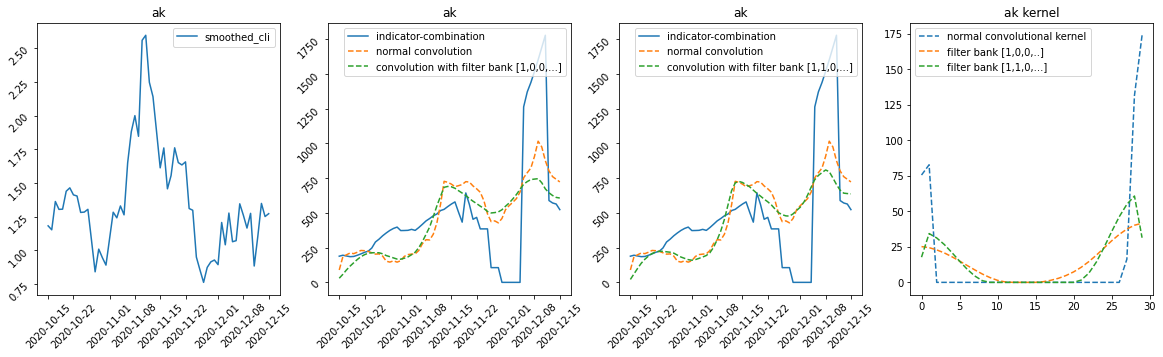

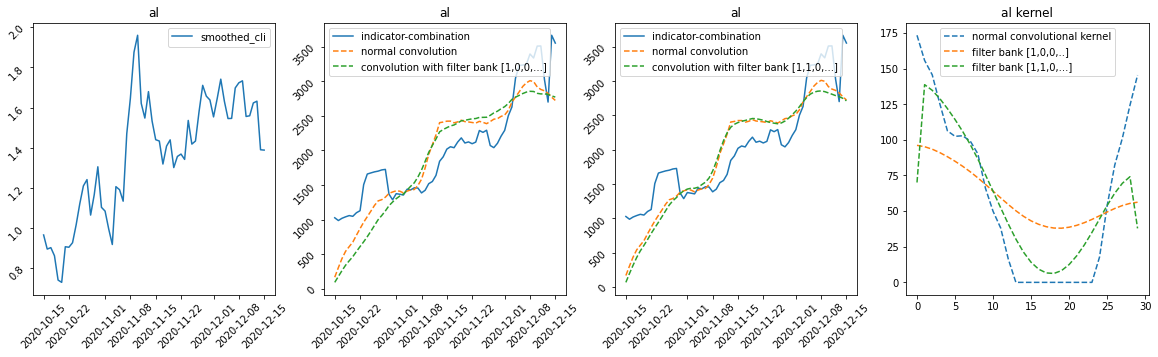

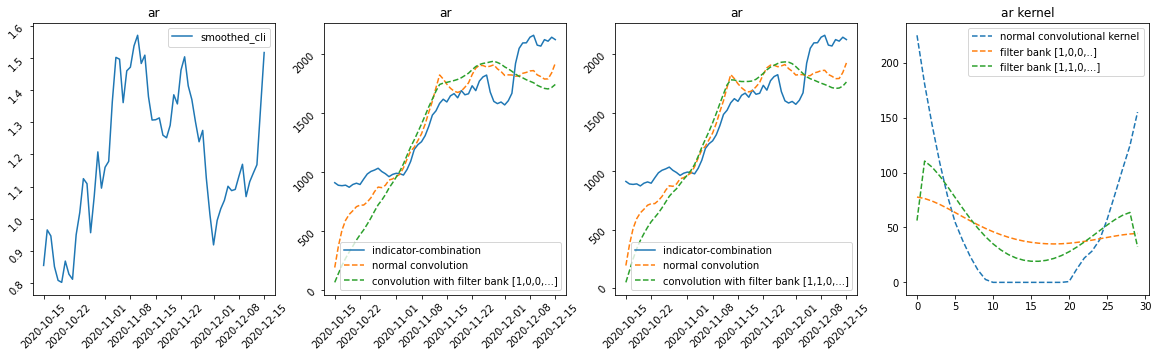

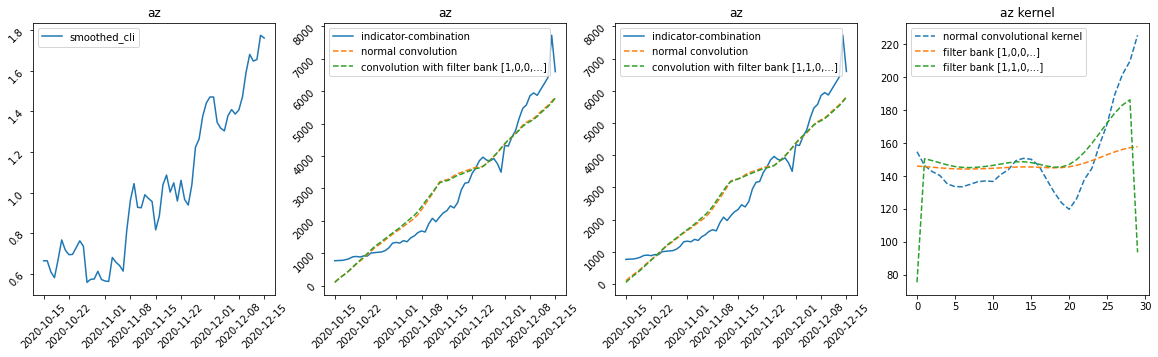

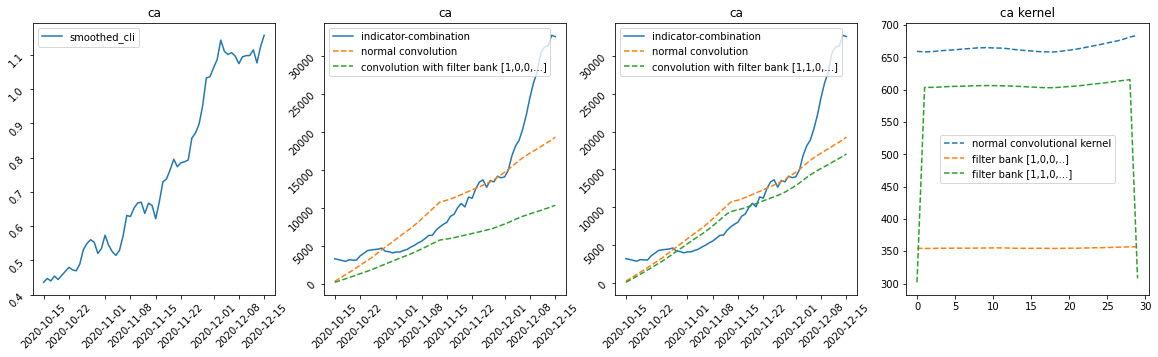

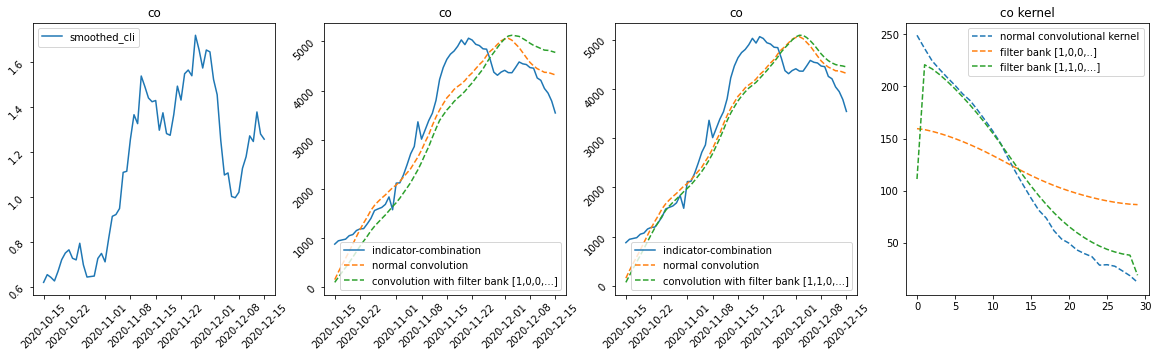

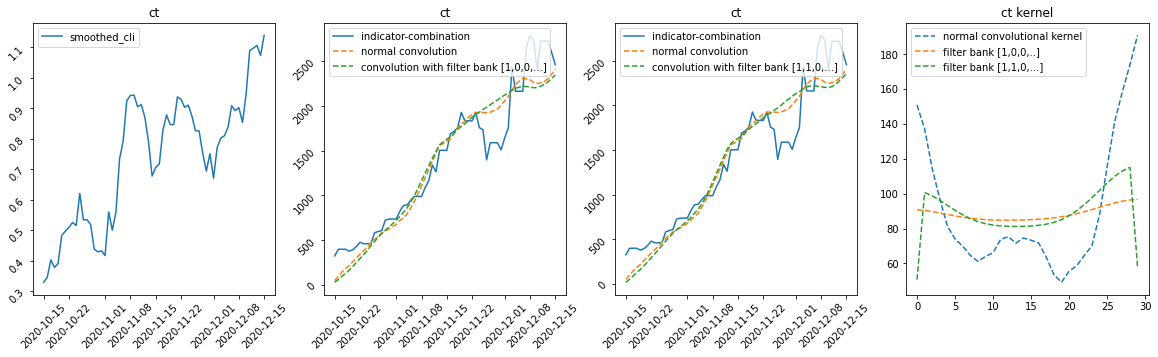

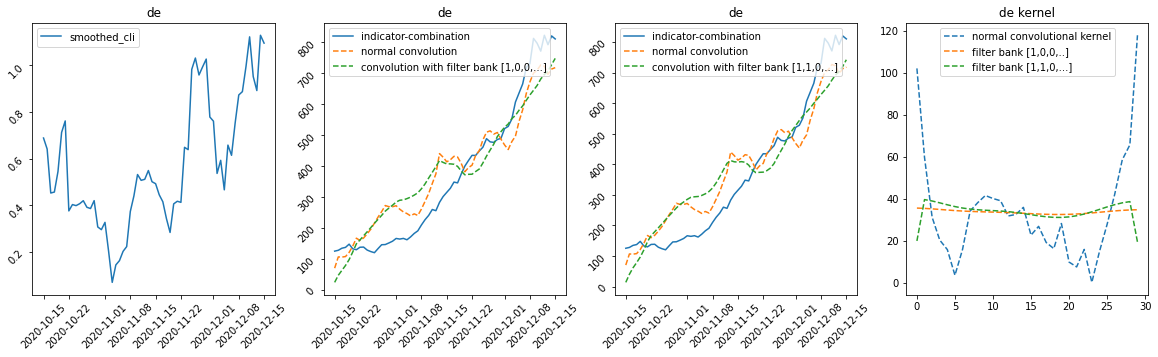

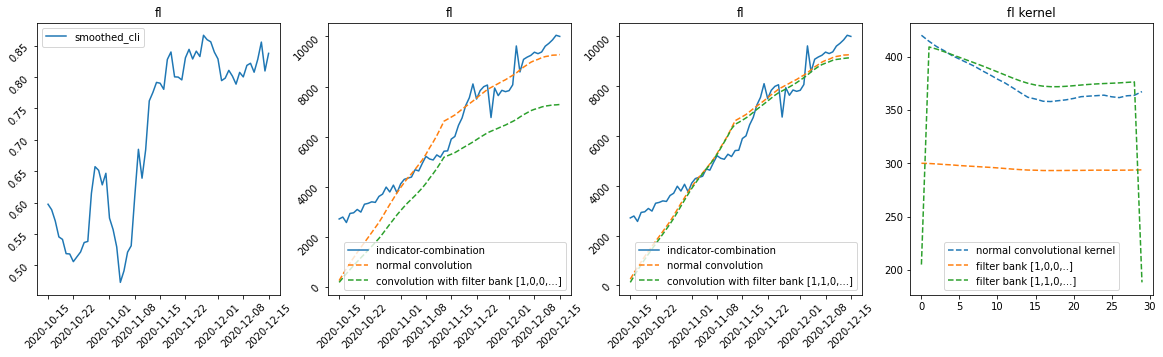

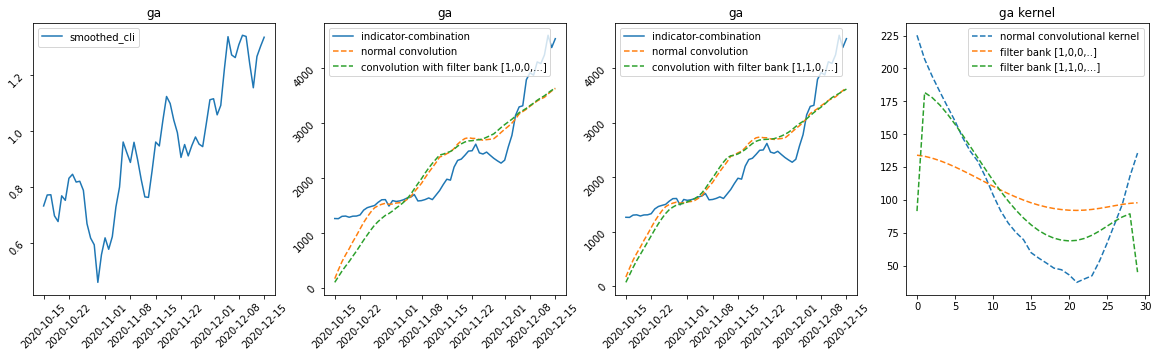

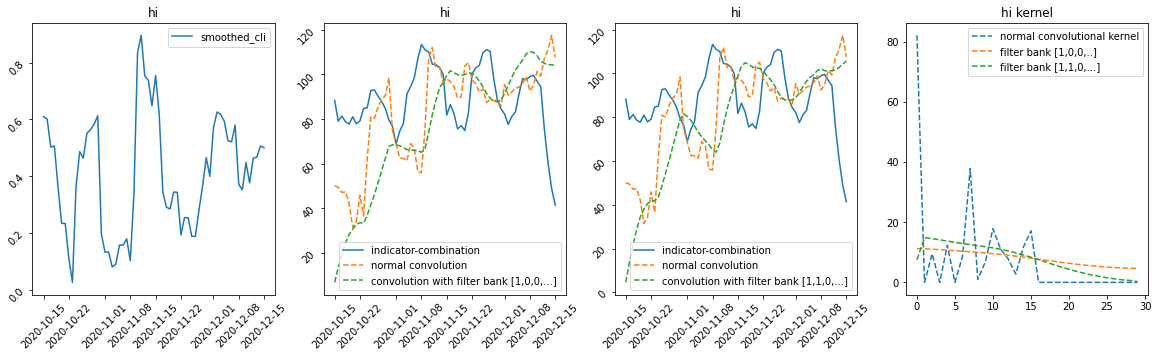

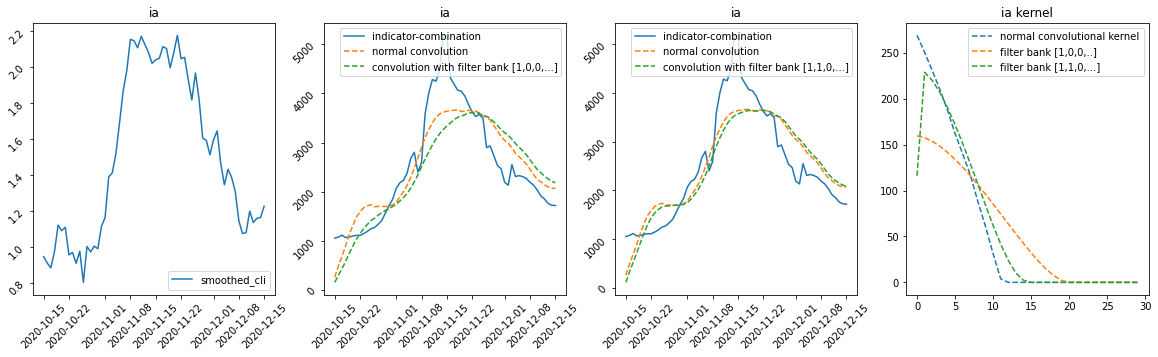

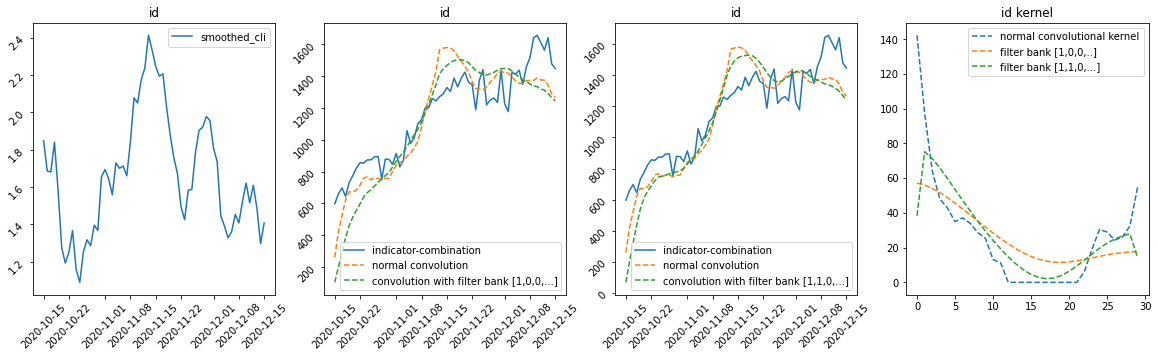

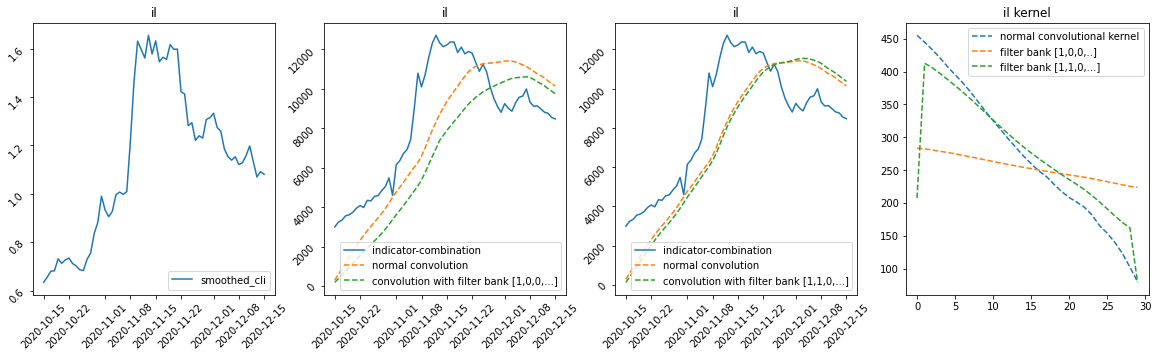

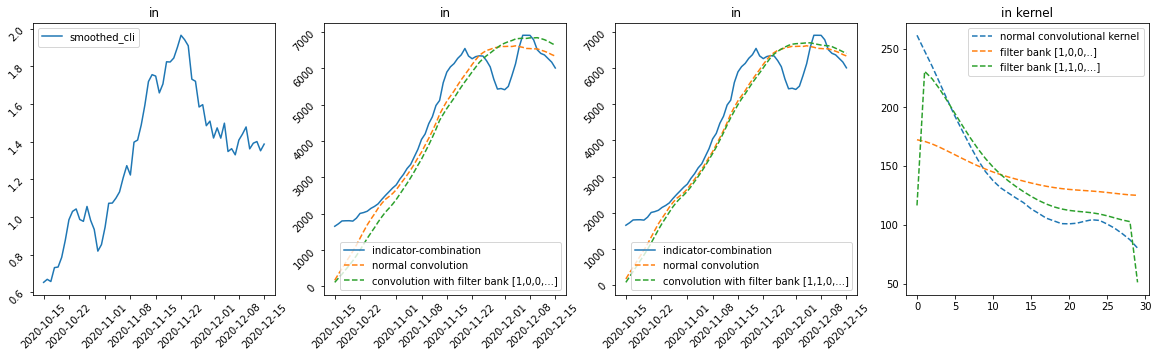

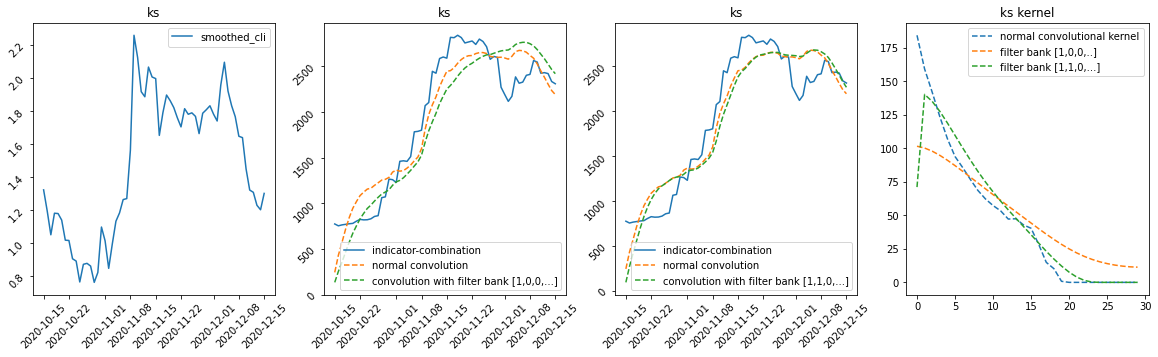

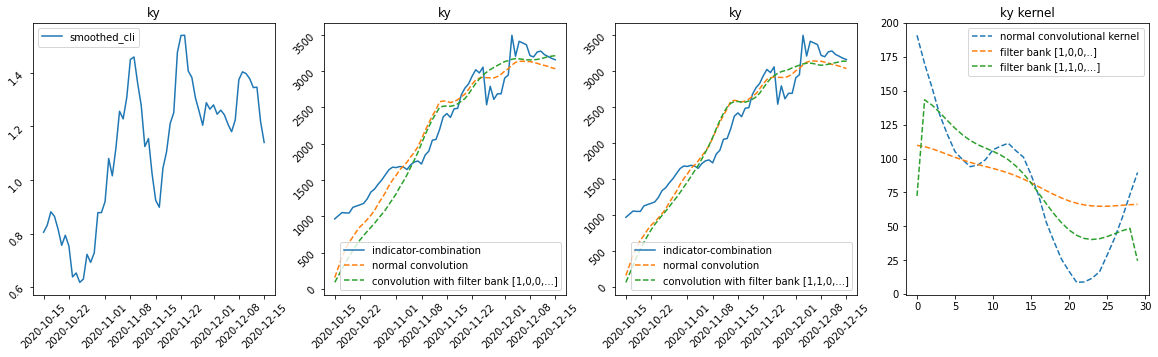

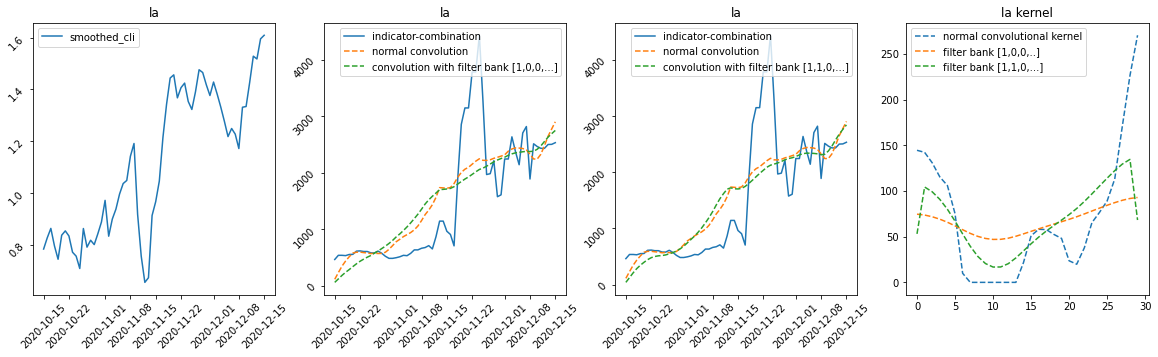

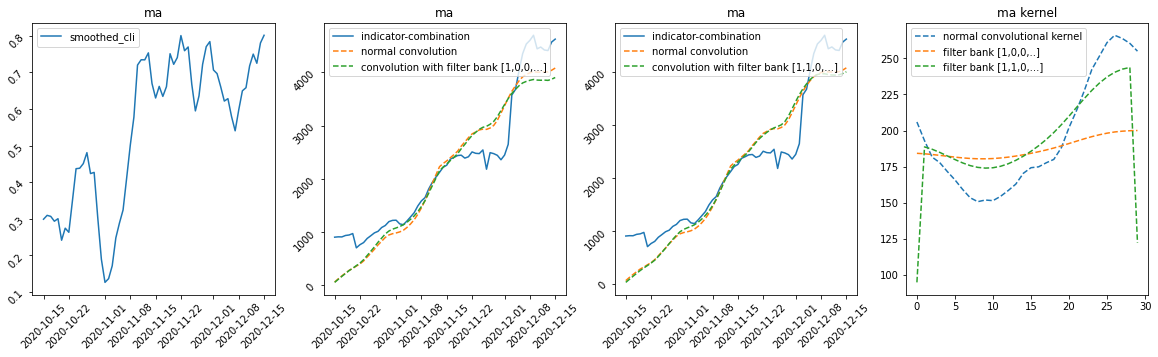

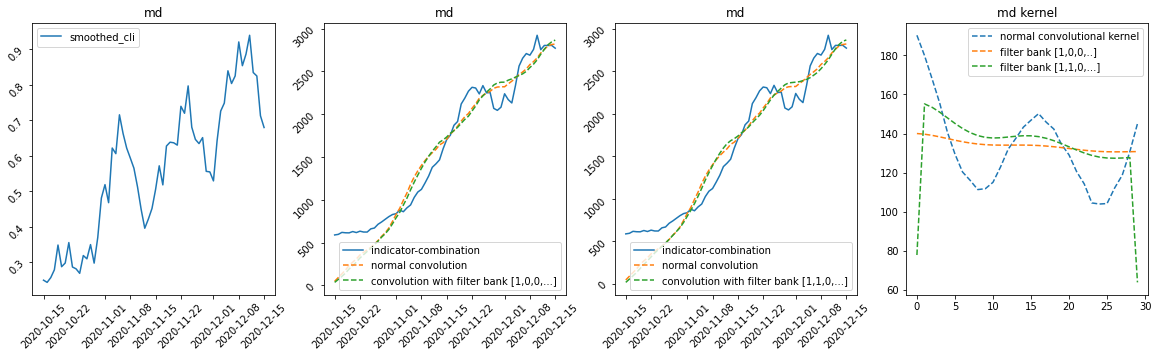

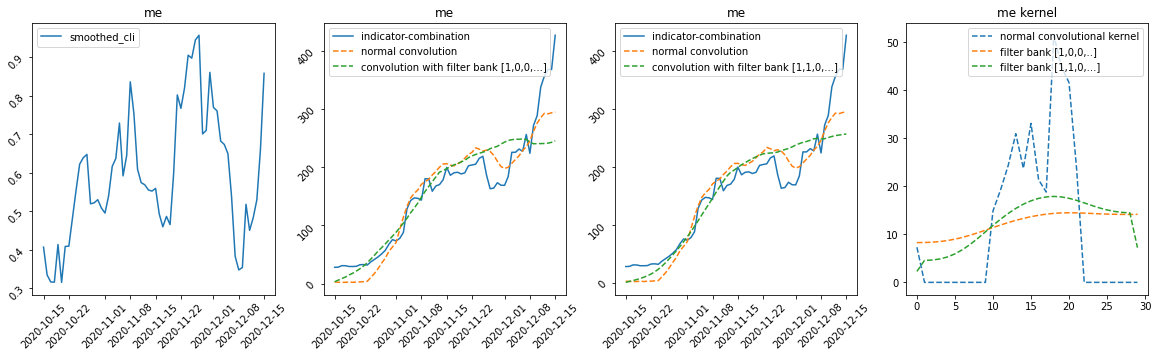

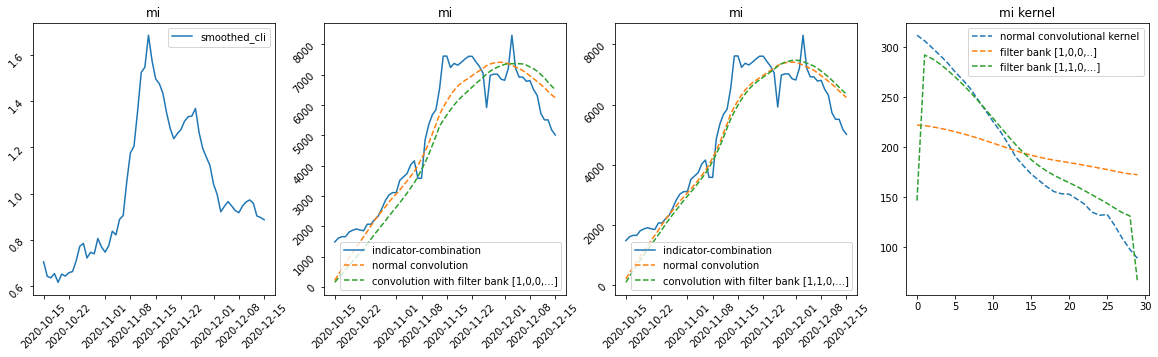

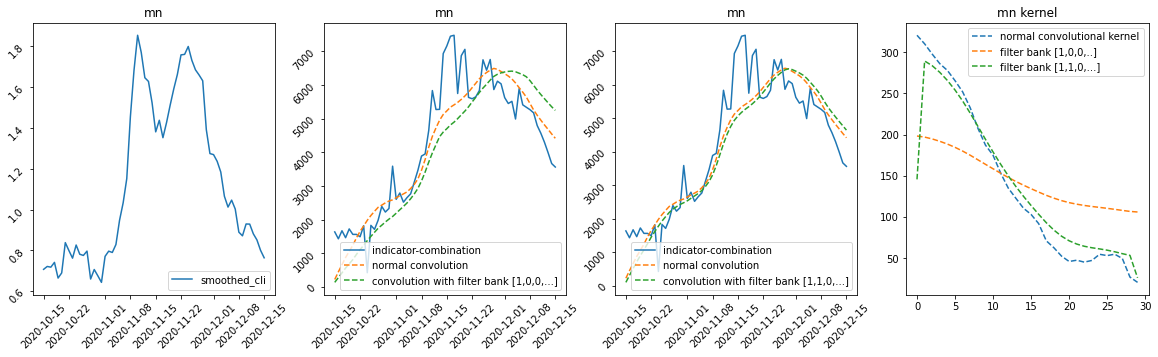

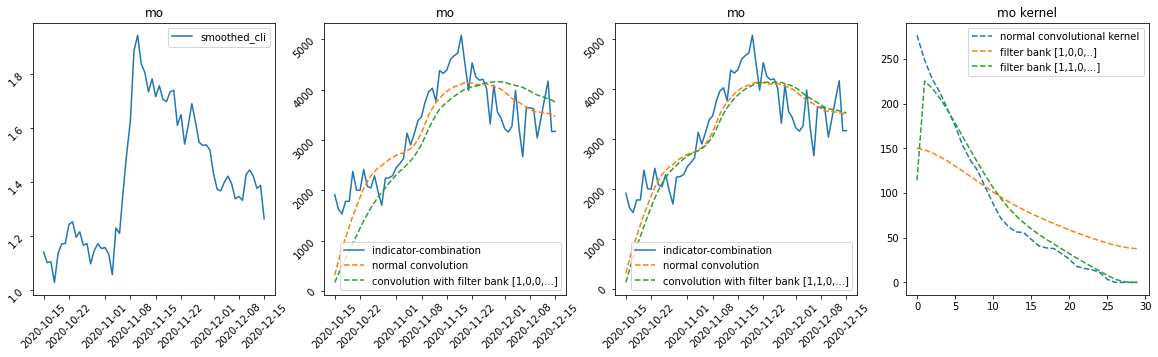

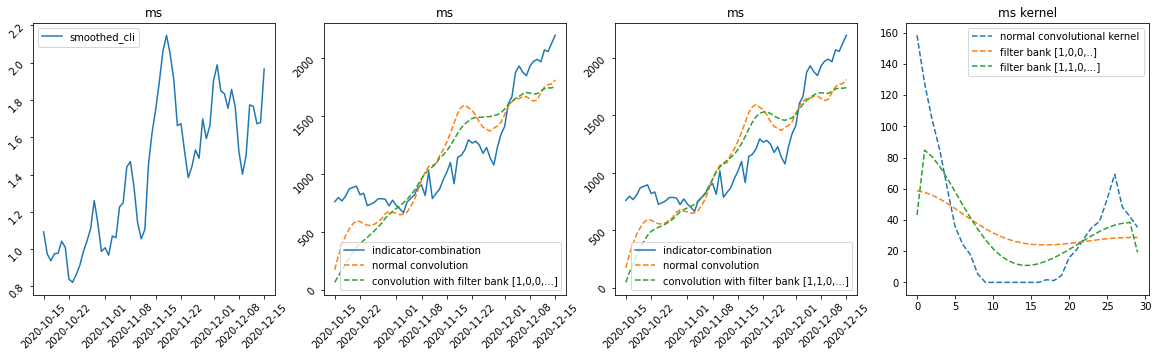

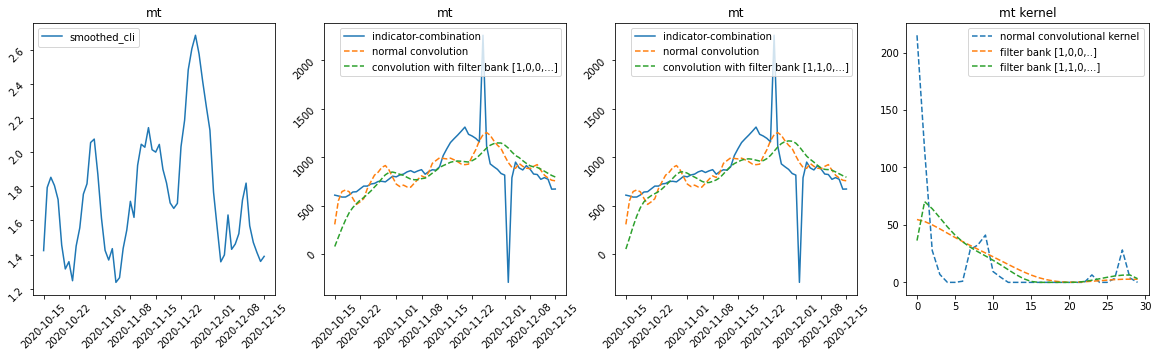

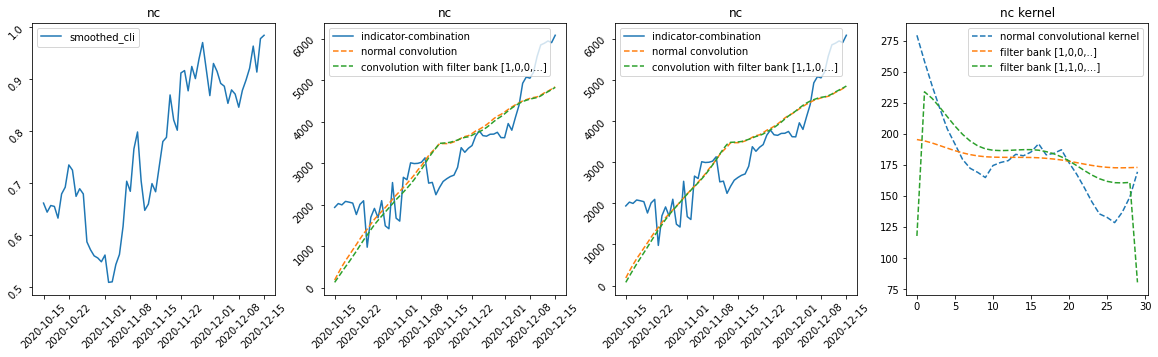

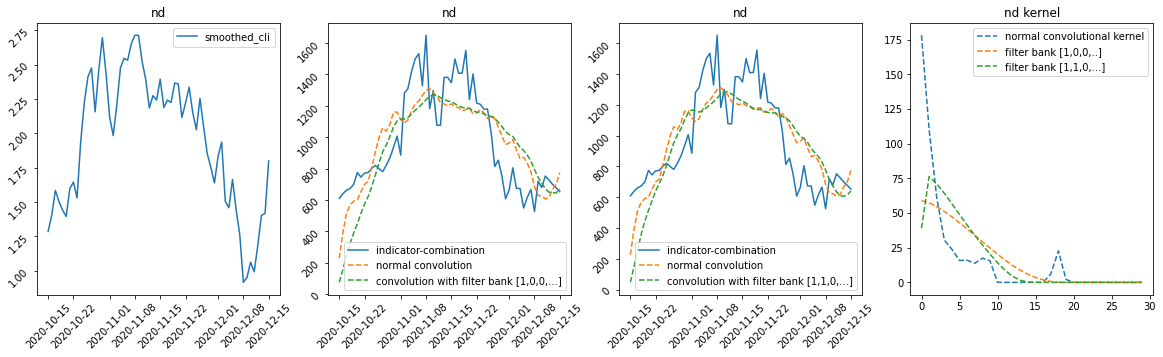

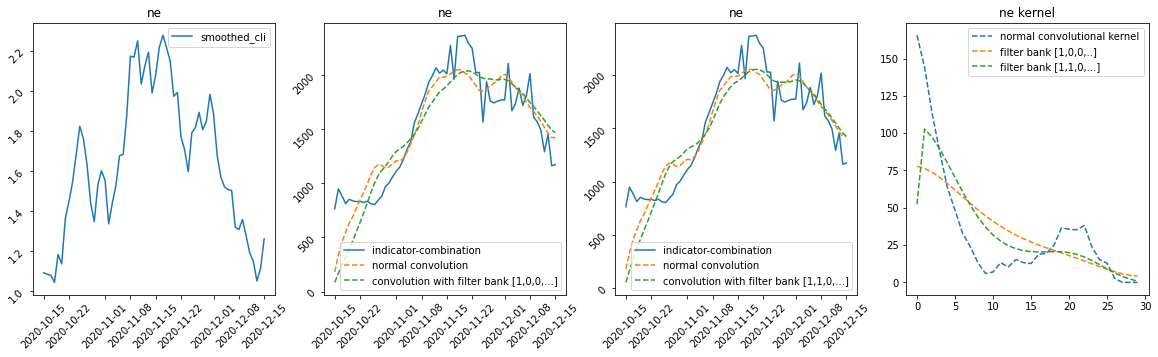

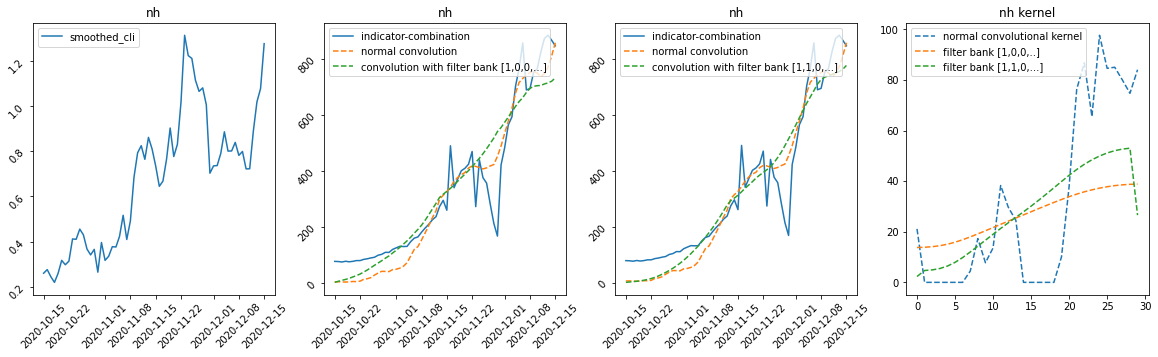

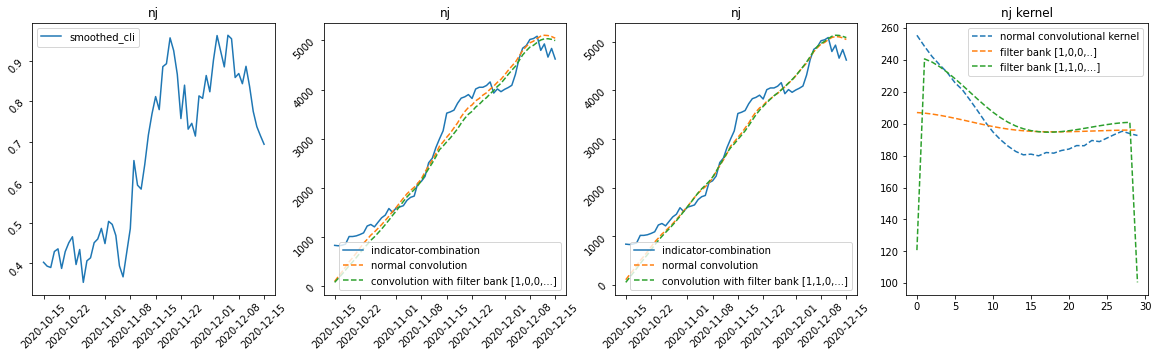

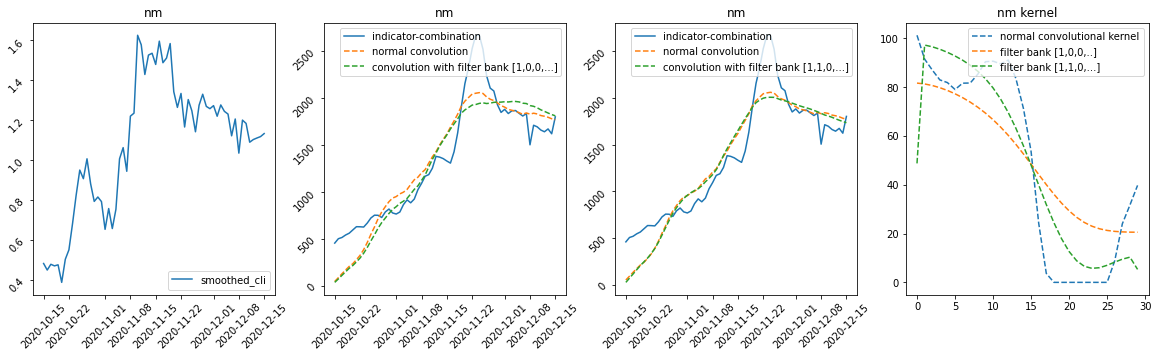

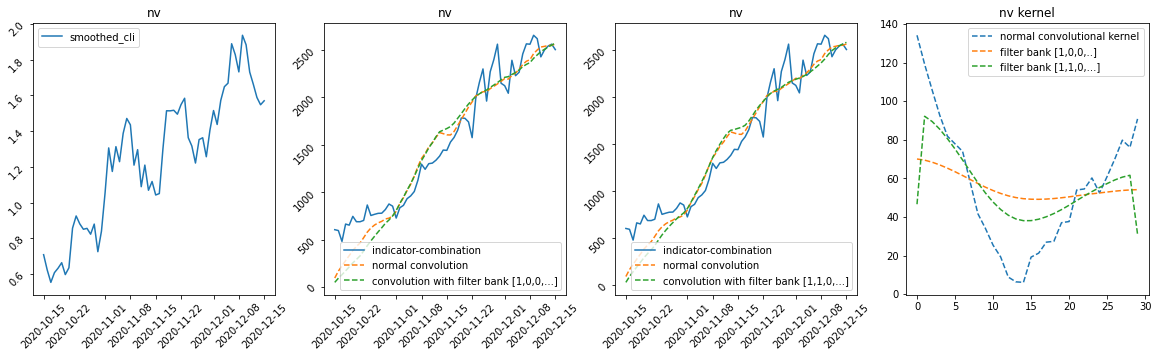

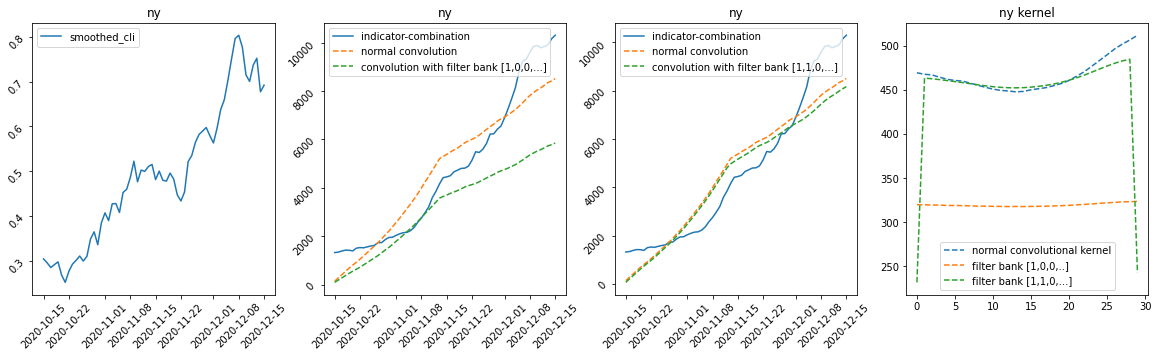

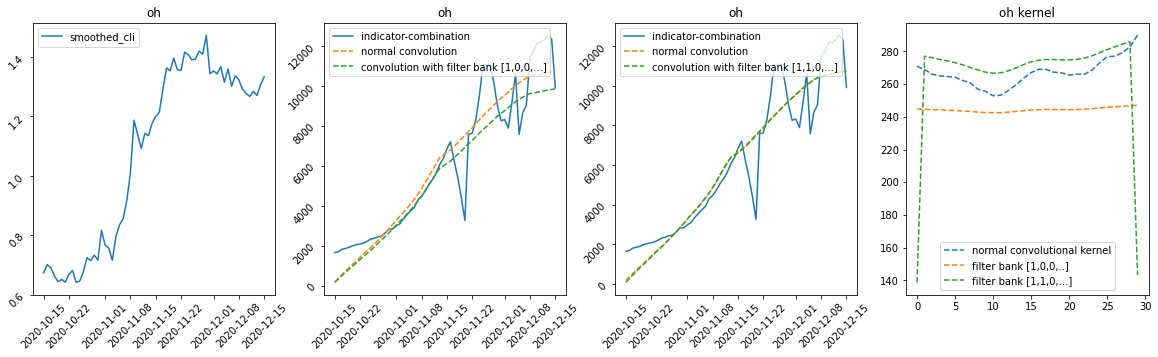

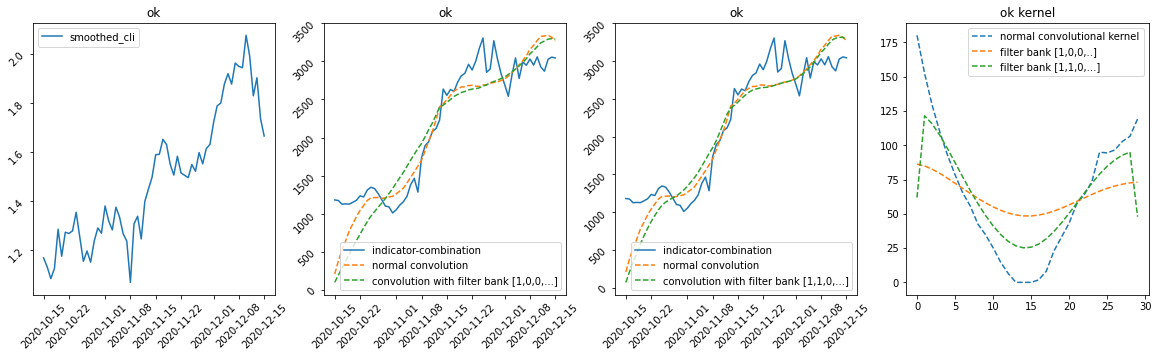

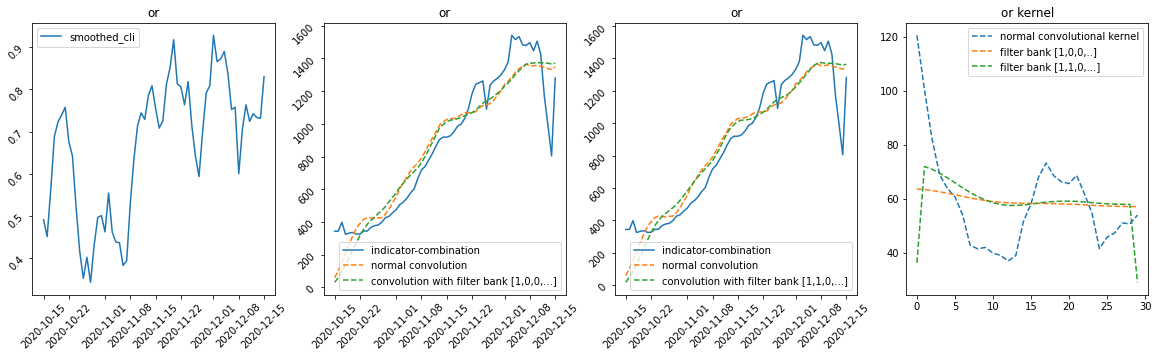

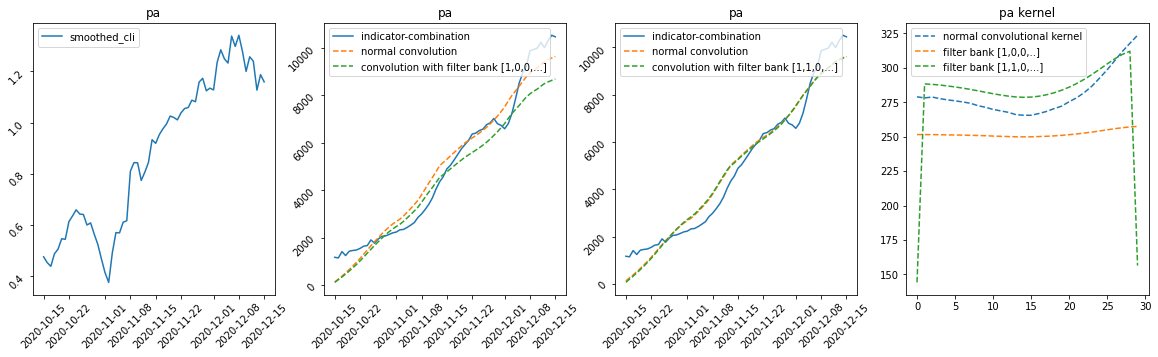

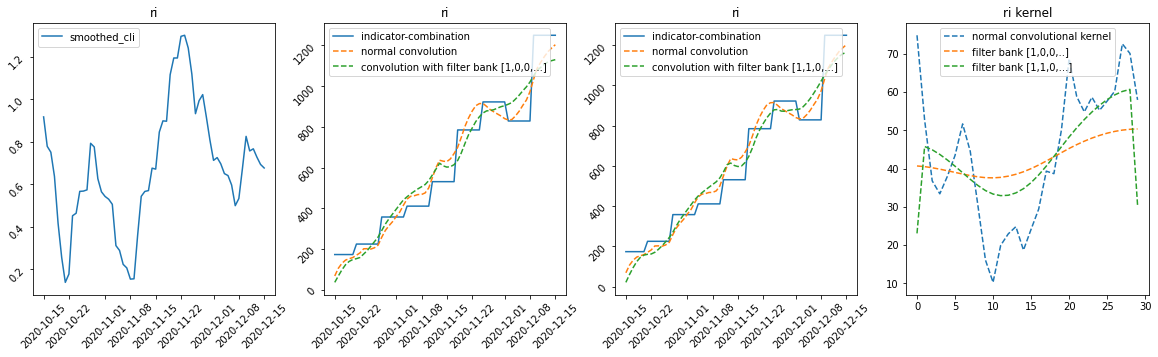

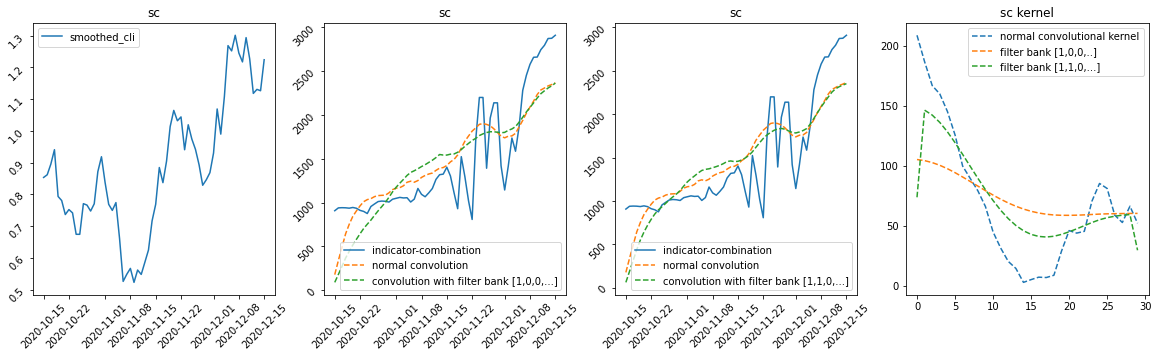

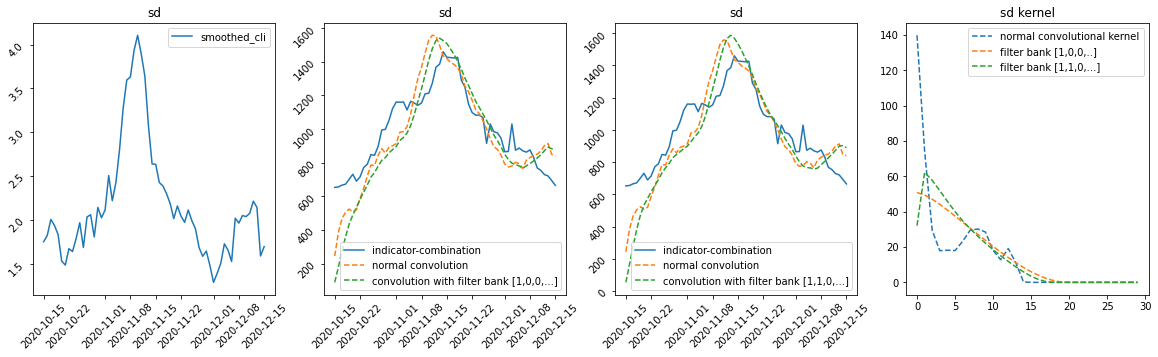

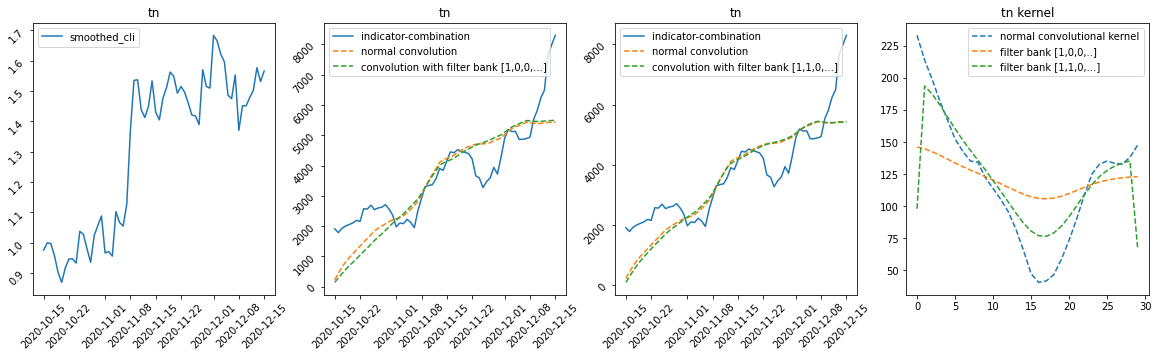

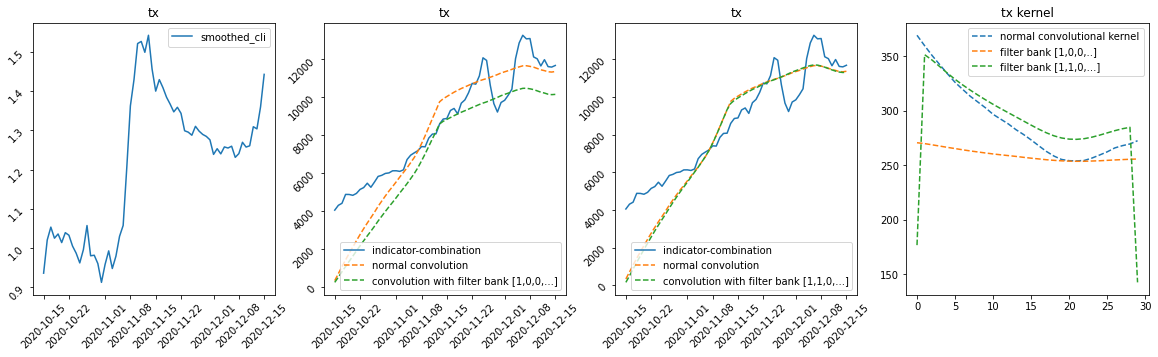

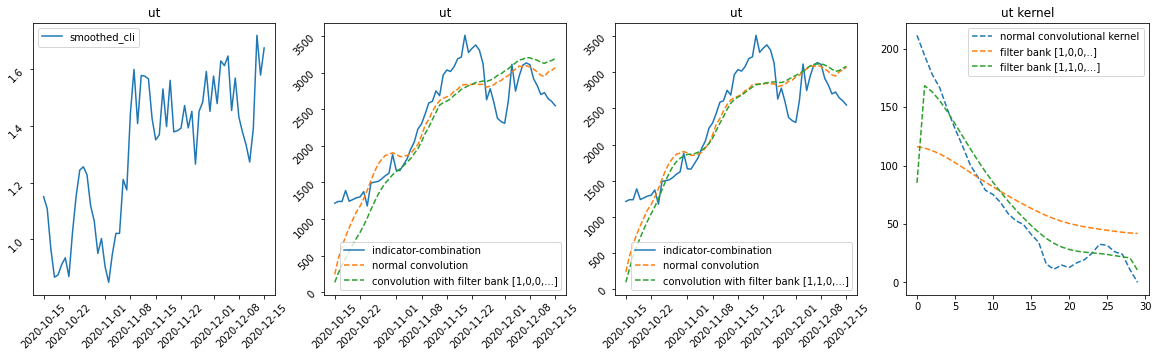

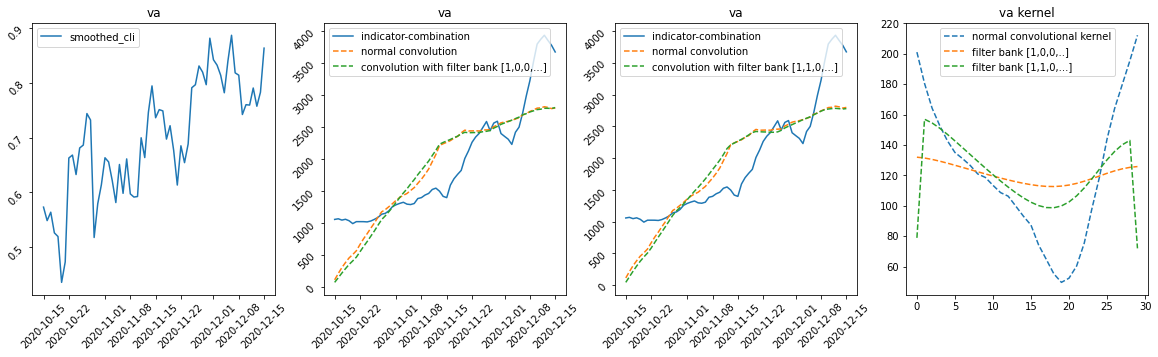

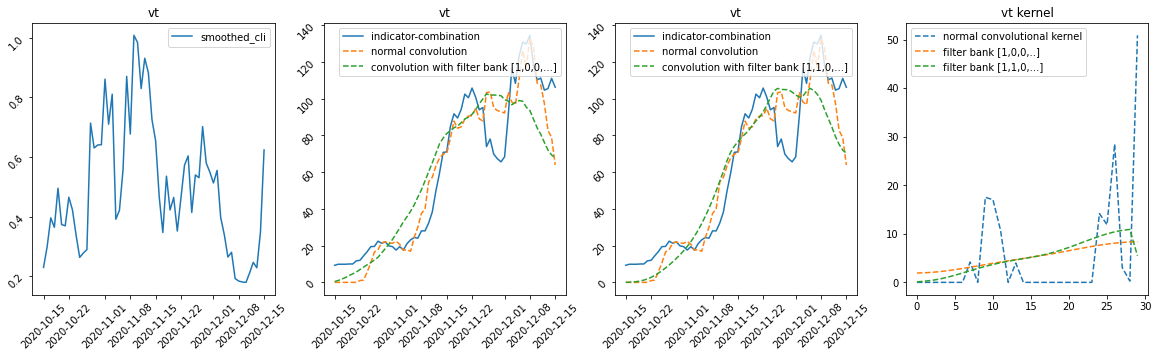

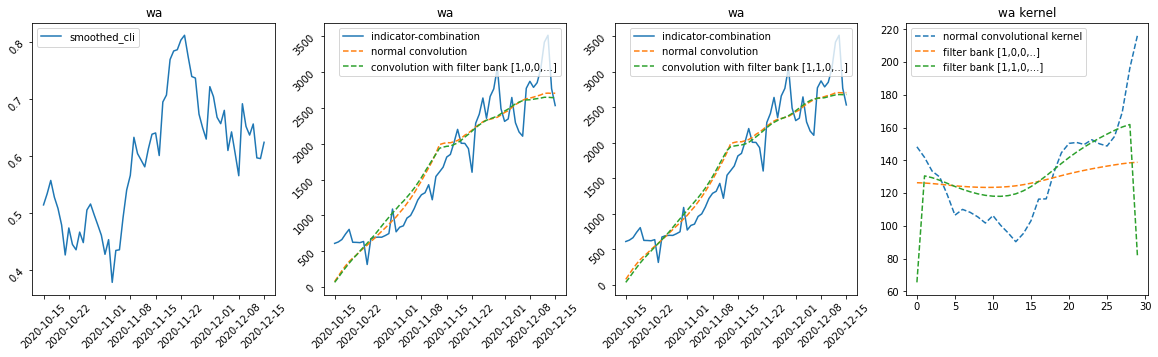

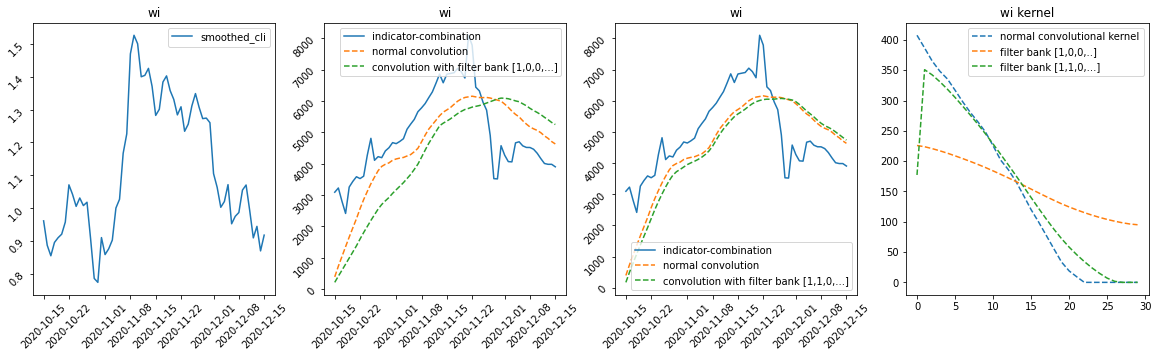

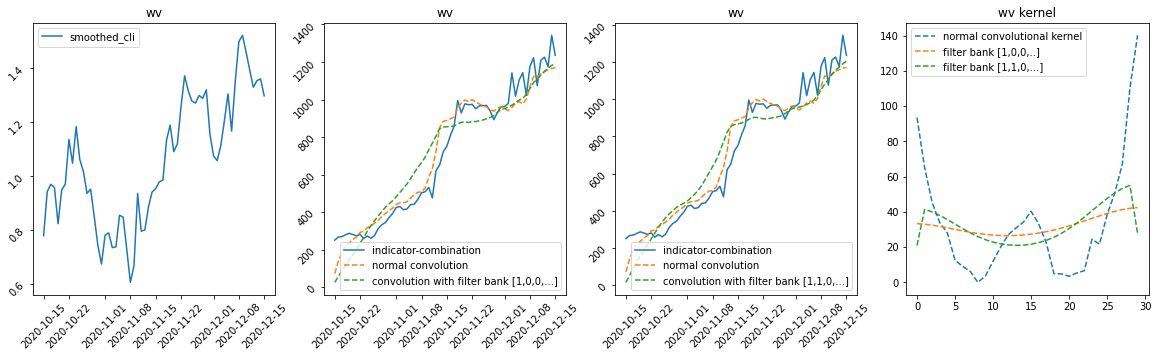

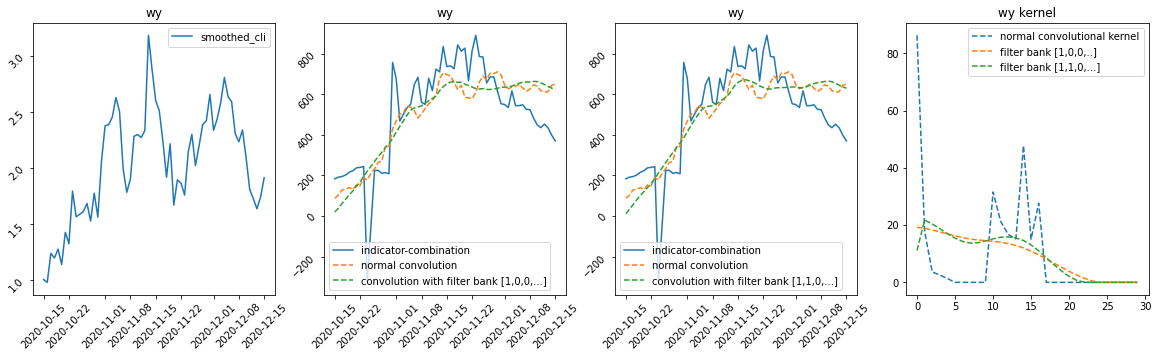

In [11]:
#Evaluation
model_a.load_weights(MODEL_A_PATH).expect_partial() #load best weights from training
model_b.load_weights(MODEL_B_PATH).expect_partial() #load best weights from training
model_c.load_weights(MODEL_C_PATH).expect_partial()

dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat_model_a = model_a(X_padded)
Y_hat_model_b = model_b(X_padded)
Y_hat_model_c = model_c(X_padded)

for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat_model_a = Y_hat_model_a[0,:,i]
    y_hat_model_b = Y_hat_model_b[0,:,i]
    y_hat_model_c = Y_hat_model_c[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    ax[0].tick_params(labelrotation=45)
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    ax[1].plot(dates, y_hat_model_b, label='convolution with filter bank [1,0,0,...]', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    ax[1].tick_params(labelrotation=45)
    
    ax[2].plot(dates, y, label='indicator-combination')
    ax[2].plot(dates, y_hat_model_a, label='normal convolution', linestyle='--')
    ax[2].plot(dates, y_hat_model_c, label='convolution with filter bank [1,1,0,...]', linestyle='--')
    ax[2].legend()
    ax[2].set_title('{}'.format(states[i]))
    ax[2].tick_params(labelrotation=45)
    
    ax[3].plot(model_a.trainable_variables[i][::-1,0,0], label='normal convolutional kernel', linestyle='--')
    ax[3].plot(get_kernel(model_b,i)[::-1], label='filter bank [1,0,0,..]', linestyle='--')
    ax[3].plot(get_kernel(model_c,i)[::-1], label='filter bank [1,1,0,...]', linestyle='--')
    ax[3].legend()
    ax[3].set_title('{} kernel'.format(states[i]))
    
    plt.show()